<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback


In [80]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [81]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [82]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)
print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [83]:
X_train_list = X_train.values;
X_test_list = X_test.values;
y_train_list = y_train.copy();

corte = int(len(X_train_list)*0.9)
X_validation = X_train_list[corte:]
X_train_list = X_train_list[:corte]
y_validation = y_train_list[corte:]
y_train_list = y_train_list[:corte]

In [93]:
# Define model
model = Sequential()
model.add(Dense(500, input_shape = (X_test.shape[1],), activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [94]:
history = model.fit(
        X_train_list,y_train_list,
        validation_data =(X_validation, y_validation),
        epochs = 100
)

Epoch 1/100
127/127 [==============================] - 2s 9ms/step - loss: 80310255616.0000 - mean_squared_error: 80310255616.0000 - val_loss: 8347905024.0000 - val_mean_squared_error: 8347905024.0000
Epoch 2/100
127/127 [==============================] - 1s 7ms/step - loss: 28891088896.0000 - mean_squared_error: 28891088896.0000 - val_loss: 8098152960.0000 - val_mean_squared_error: 8098152960.0000
Epoch 3/100
127/127 [==============================] - 1s 10ms/step - loss: 27959711744.0000 - mean_squared_error: 27959711744.0000 - val_loss: 9298029568.0000 - val_mean_squared_error: 9298029568.0000
Epoch 4/100
127/127 [==============================] - 1s 7ms/step - loss: 28285042688.0000 - mean_squared_error: 28285042688.0000 - val_loss: 7912461312.0000 - val_mean_squared_error: 7912461312.0000
Epoch 5/100
127/127 [==============================] - 1s 7ms/step - loss: 28659396608.0000 - mean_squared_error: 28659396608.0000 - val_loss: 8316926976.0000 - val_mean_squared_error: 8316926976

In [95]:
predictions = model.predict(X_test_list)

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9691276874810848, 64514.46, 94268.43)

In [96]:
precisao = model.predict(X_train_list)

r2_score(y_train_list, precisao), mean_absolute_error(y_train_list, precisao), np.sqrt(mean_squared_error(y_train_list, precisao))

(0.9449117965813693, 78103.39, 136437.0)

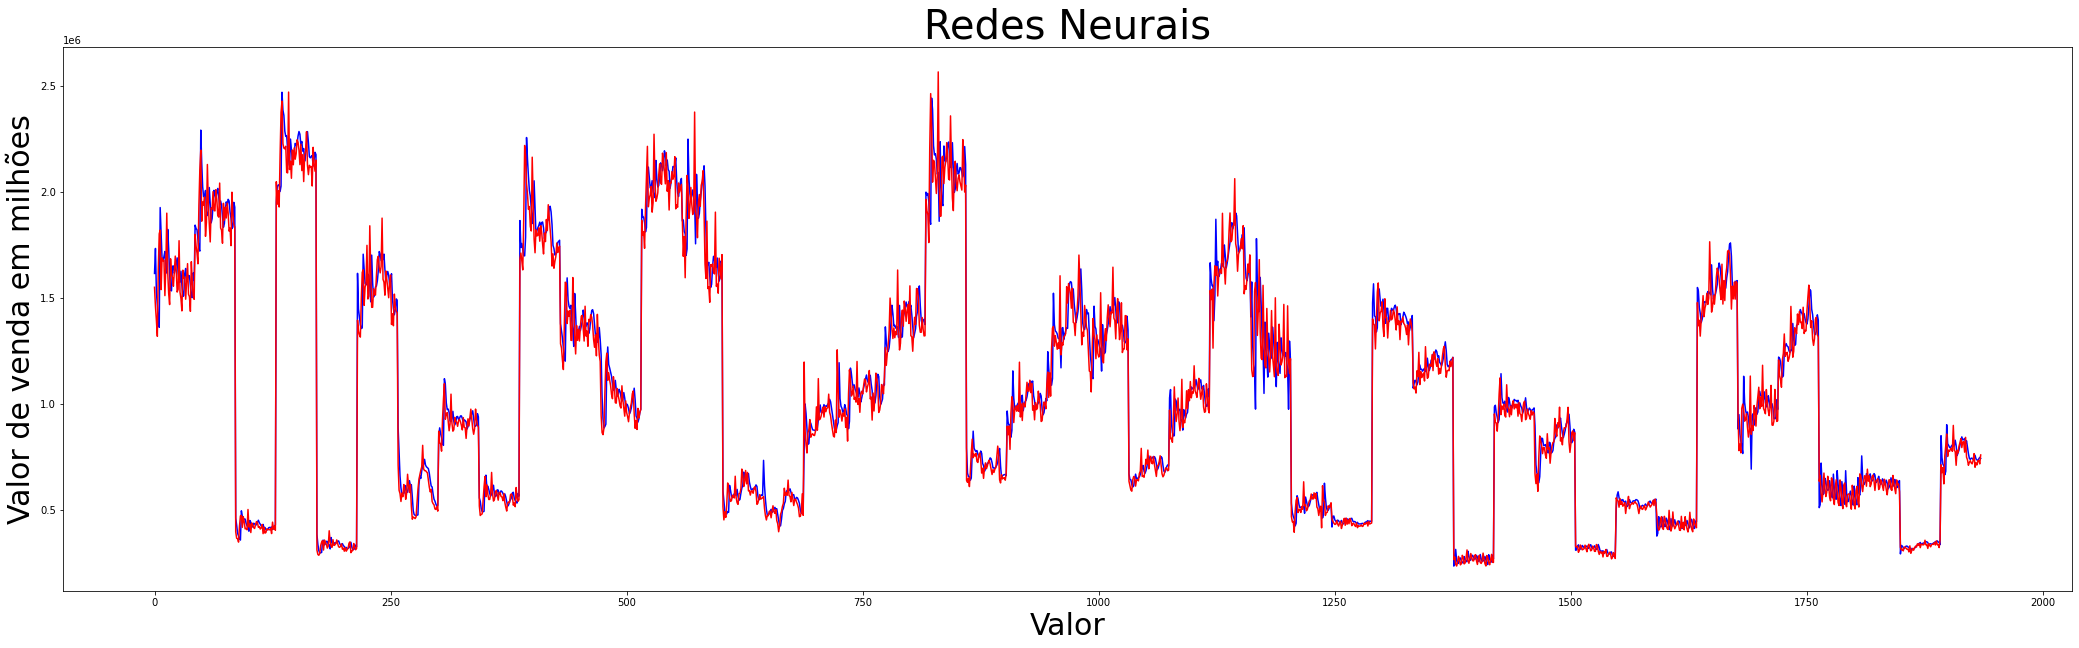

In [97]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Redes Neurais", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

Resultados Loja 1:
119921.945 149042.44


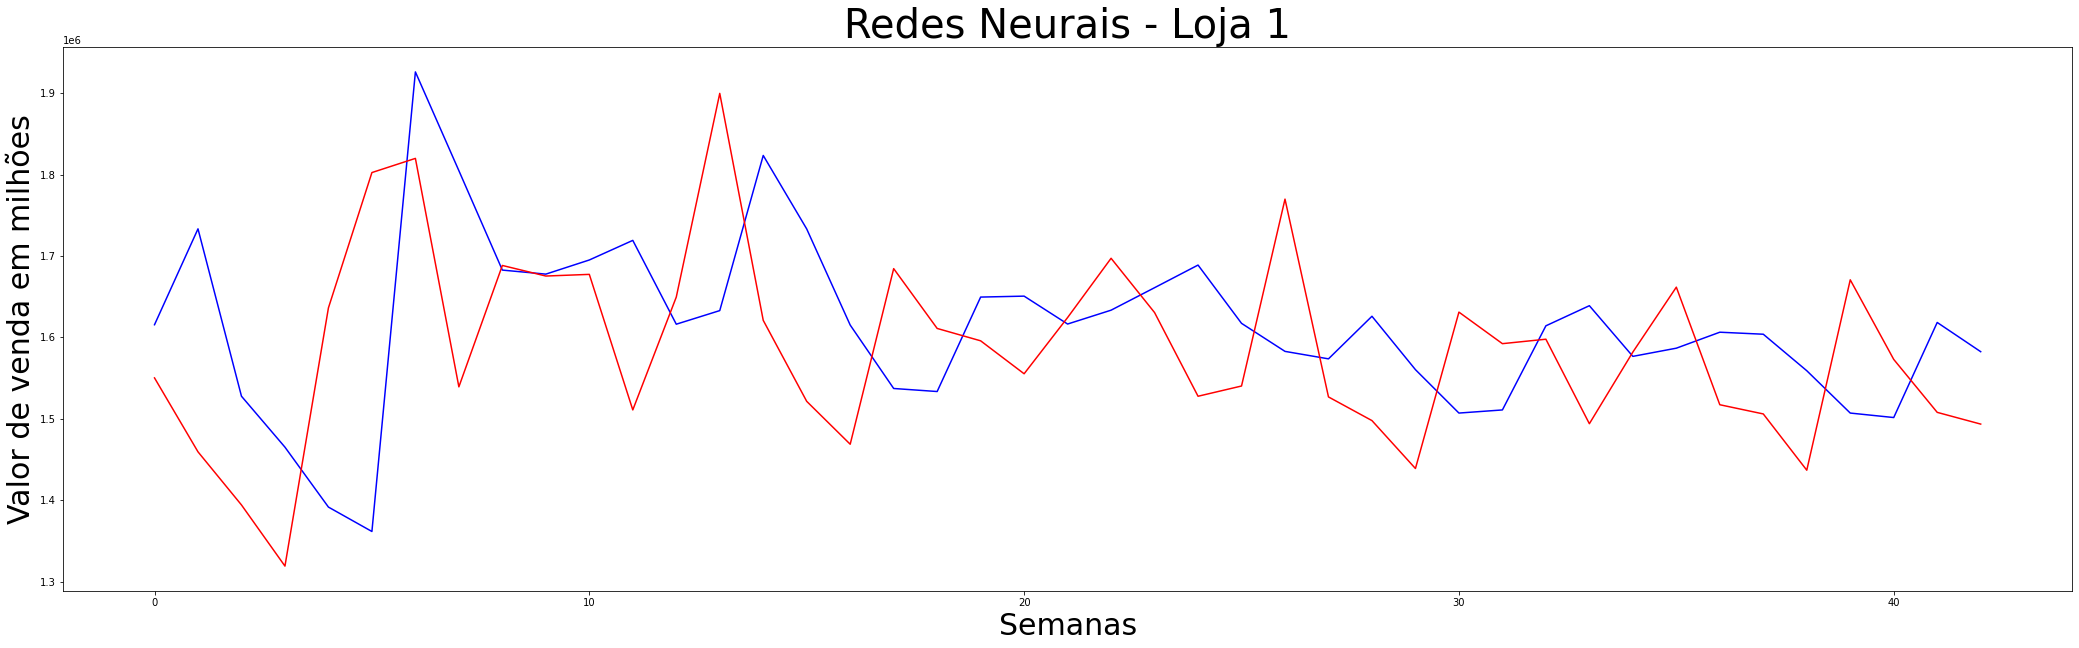

**************************************************
Resultados Loja 2:
104582.21 128653.56


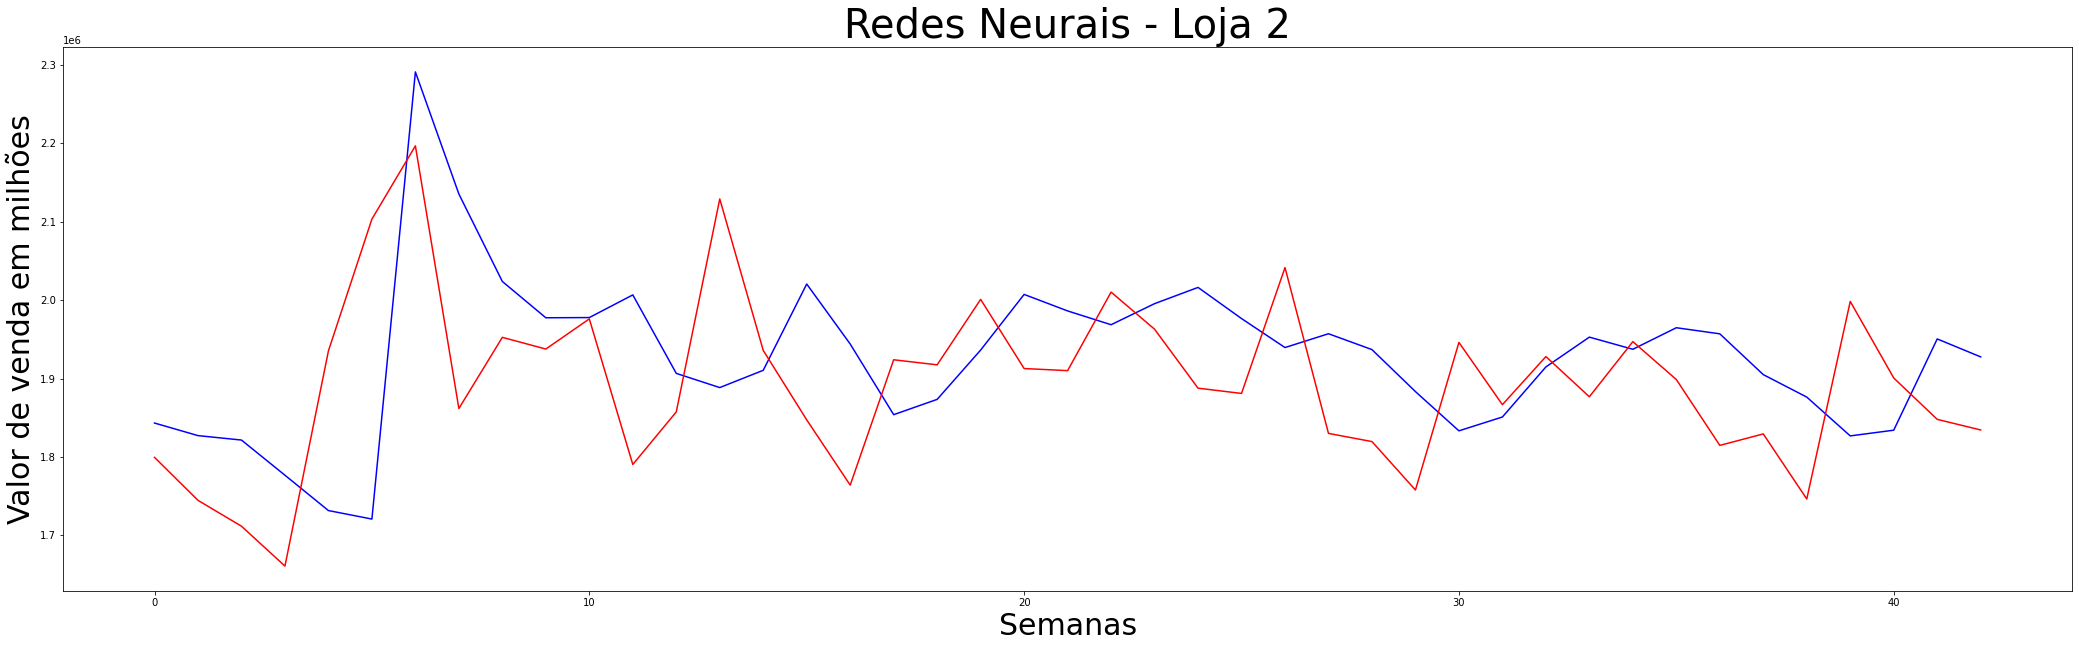

**************************************************
Resultados Loja 3:
25724.361 34775.047


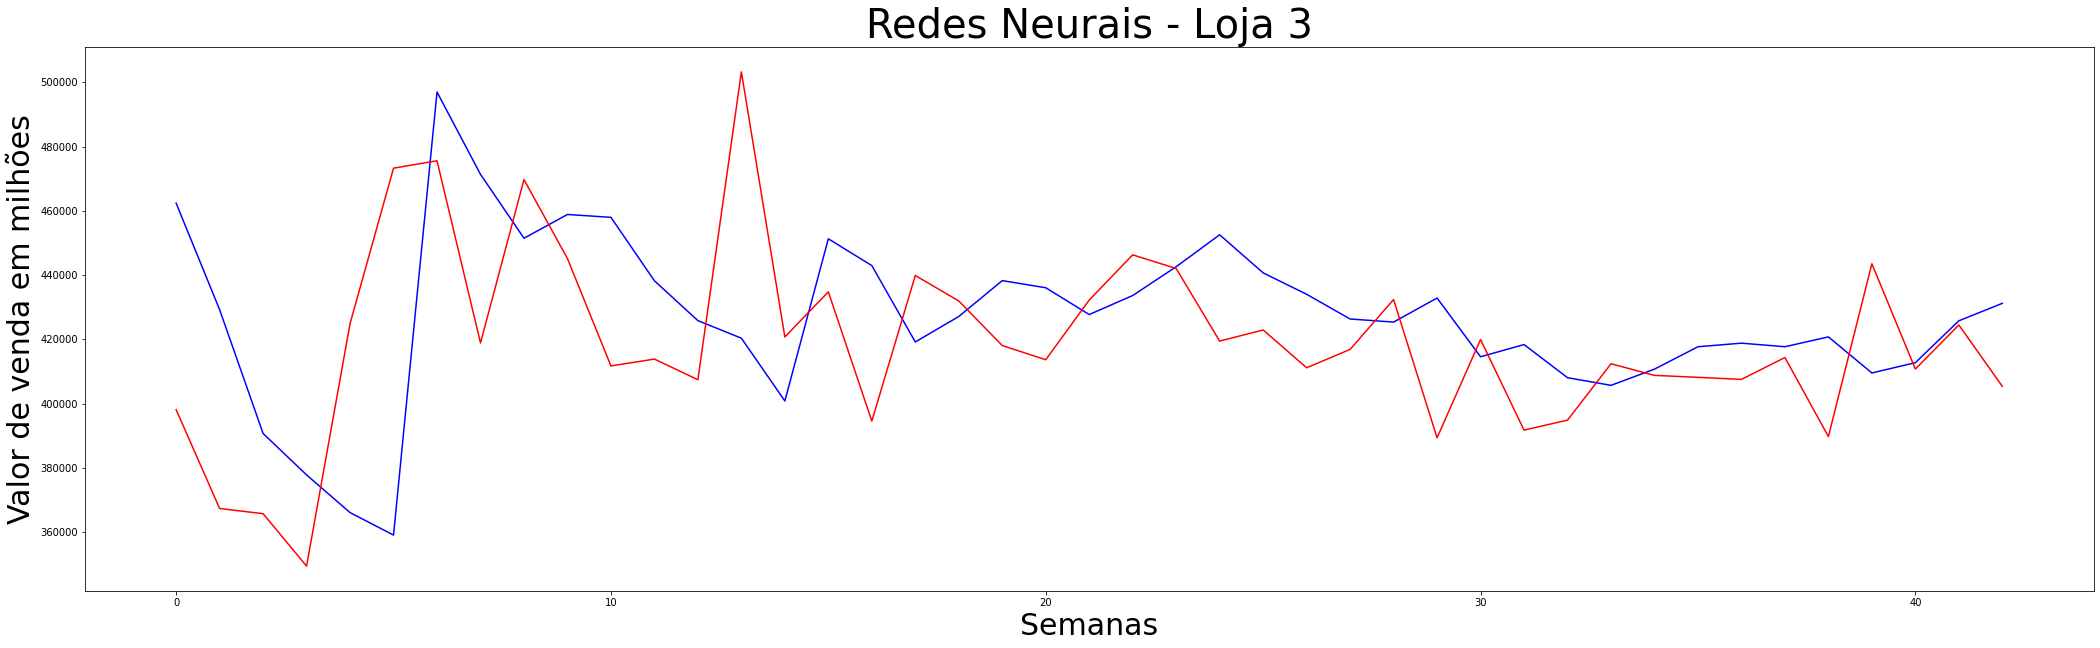

**************************************************
Resultados Loja 4:
91431.836 117401.055


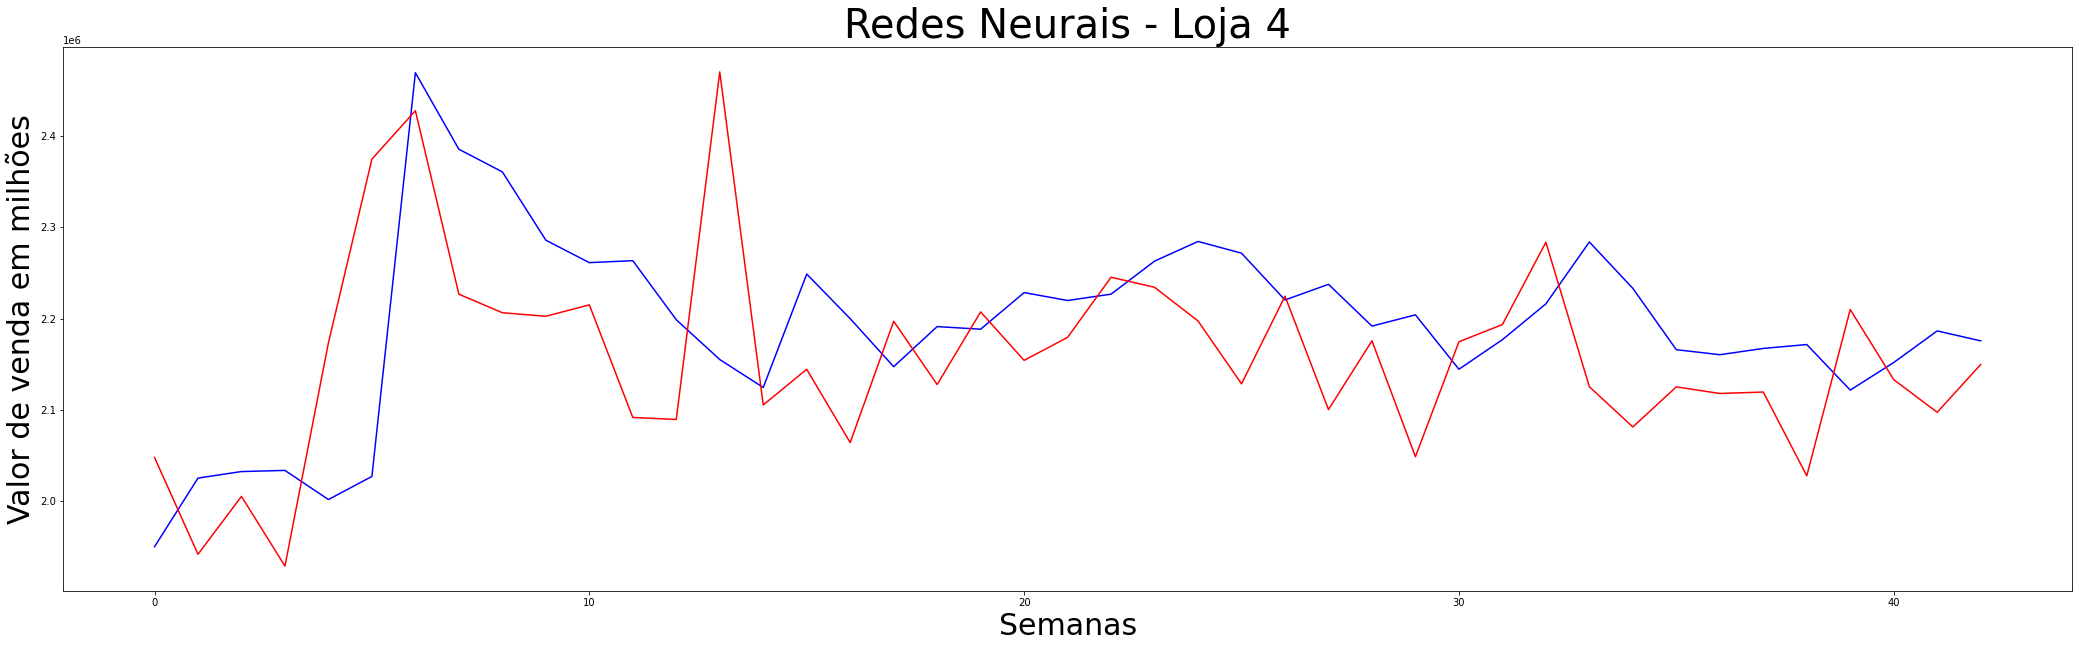

**************************************************
Resultados Loja 5:
21202.867 27465.062


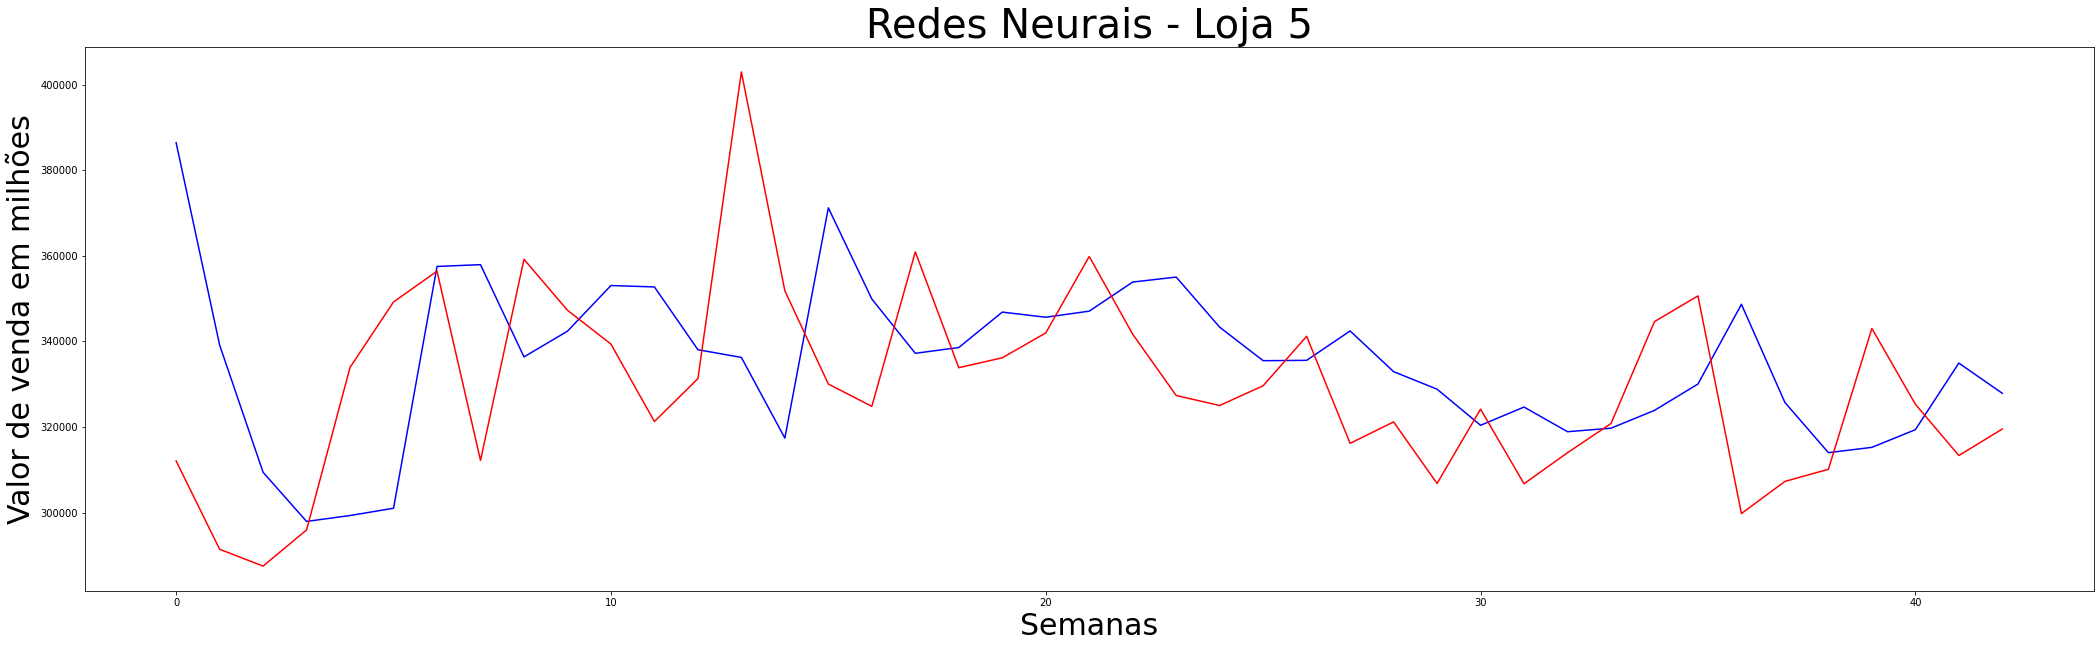

**************************************************
Resultados Loja 6:
98716.08 121893.48


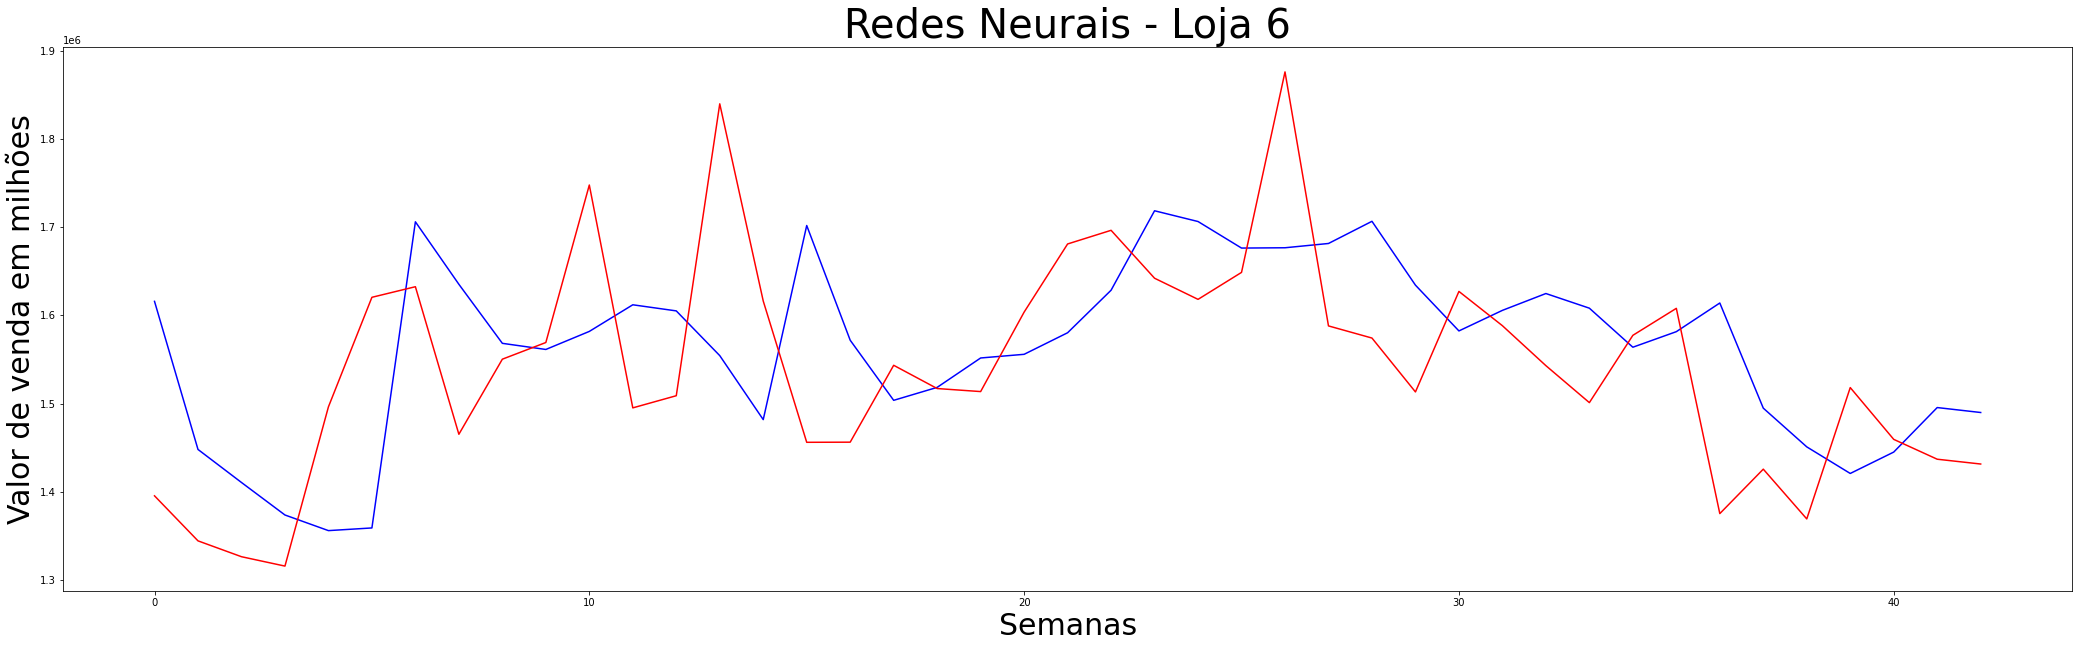

**************************************************
Resultados Loja 7:
46860.14 63142.754


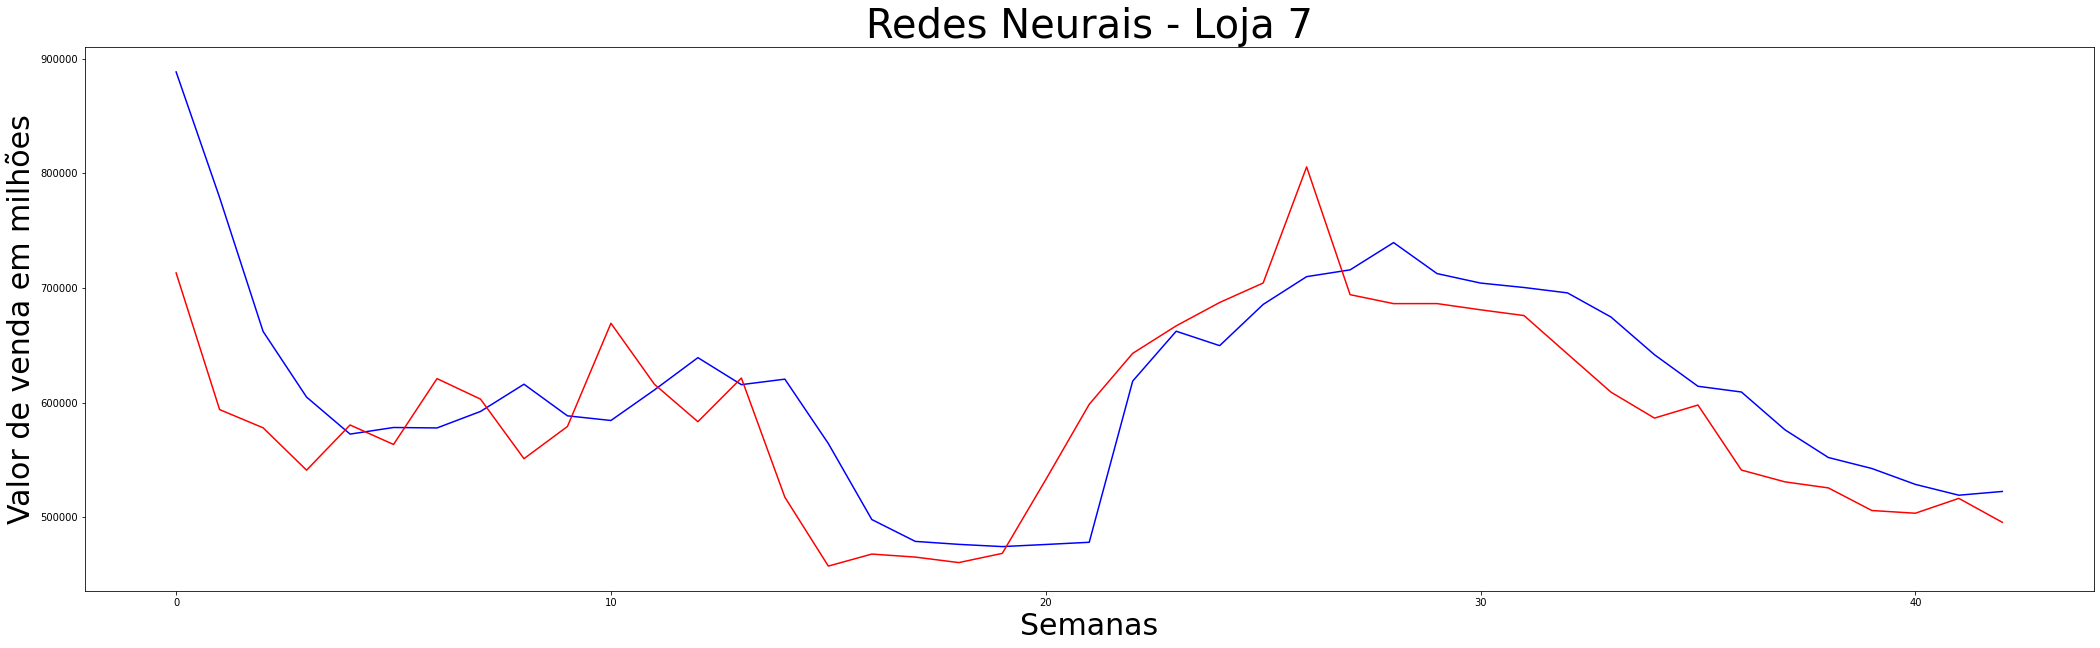

**************************************************
Resultados Loja 8:
50124.883 66001.91


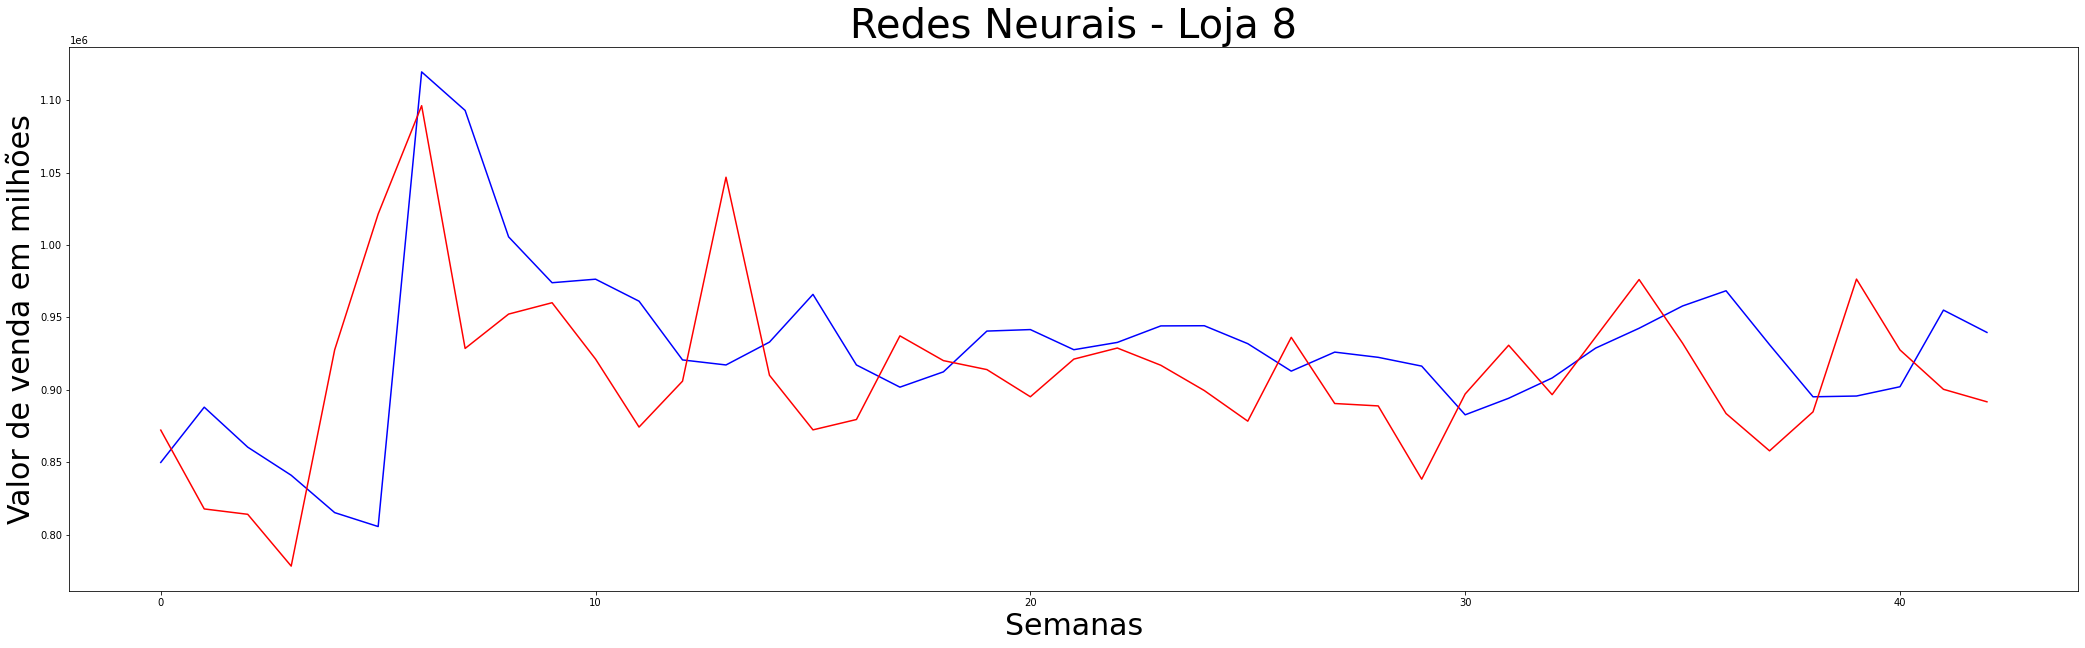

**************************************************
Resultados Loja 9:
34894.2 43697.242


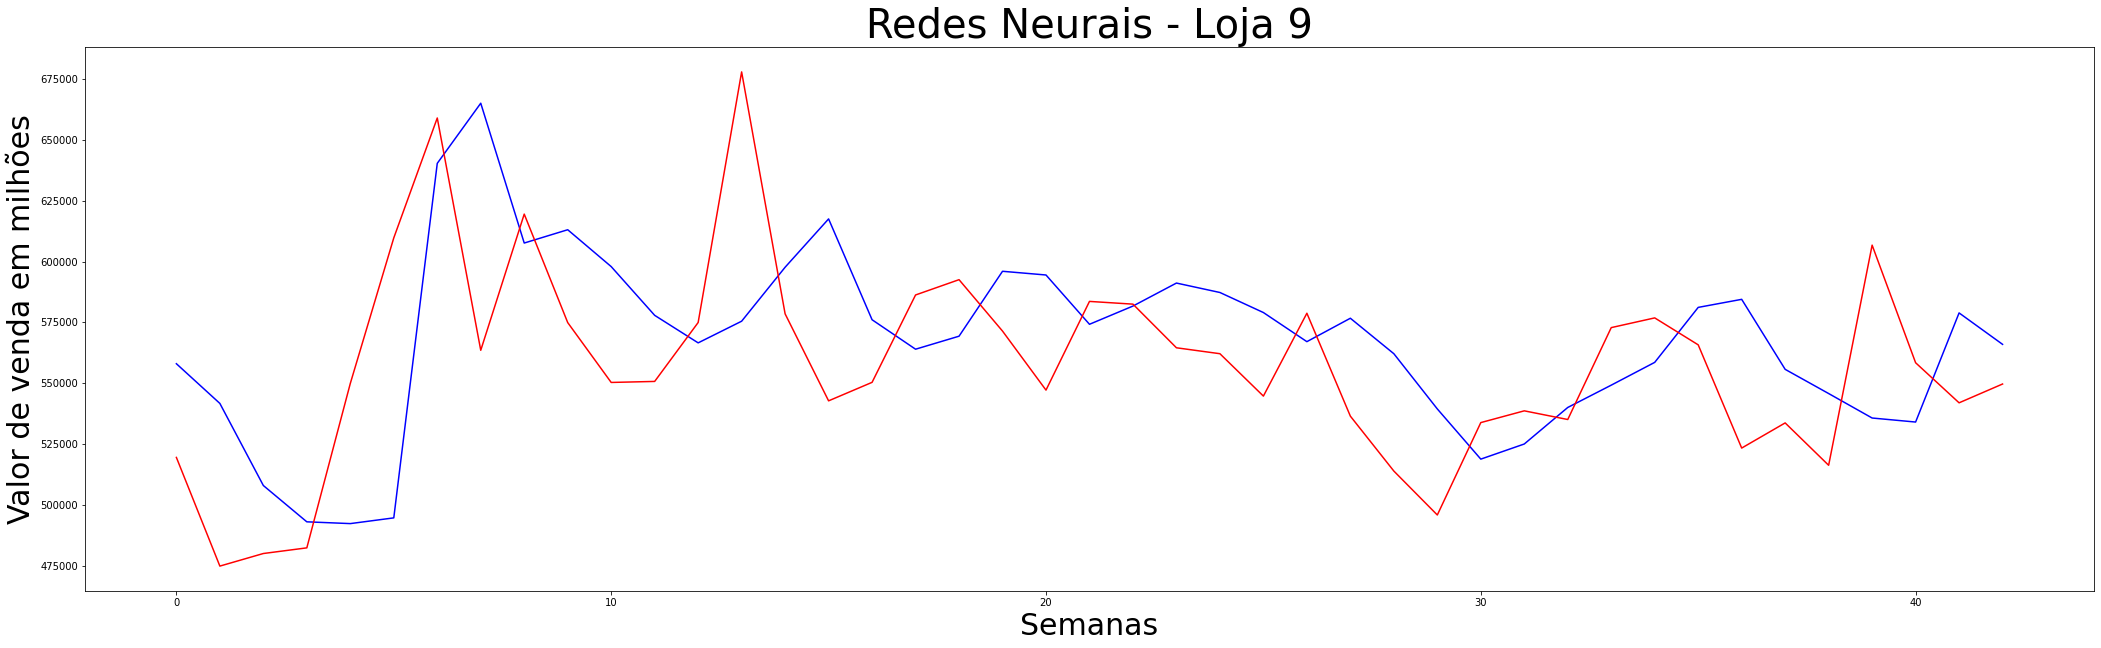

**************************************************
Resultados Loja 10:
109468.67 151060.36


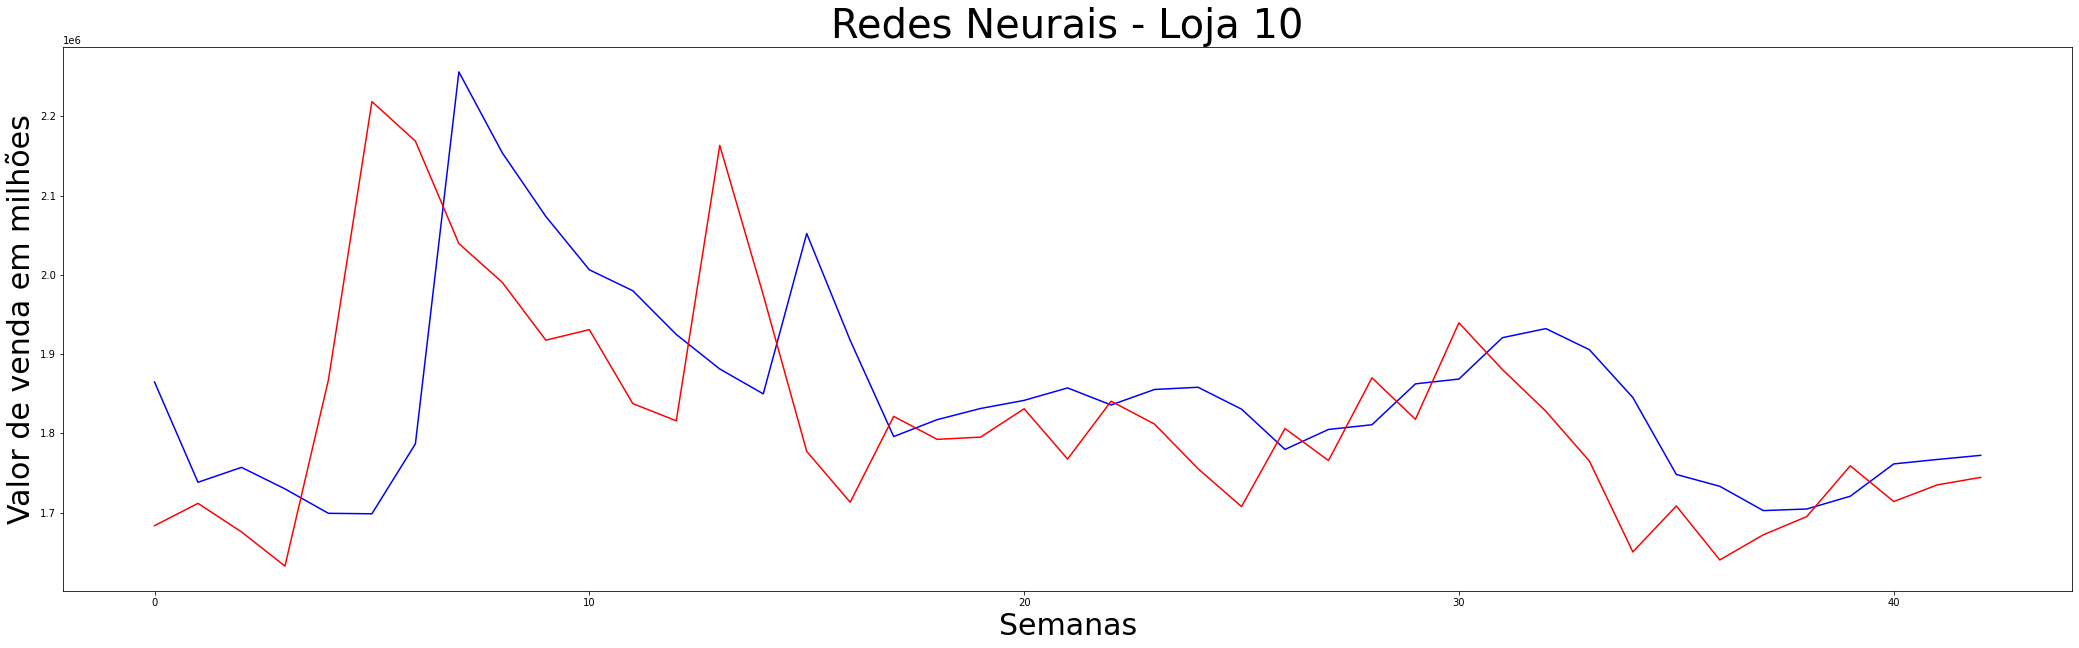

**************************************************
Resultados Loja 11:
95118.45 120762.055


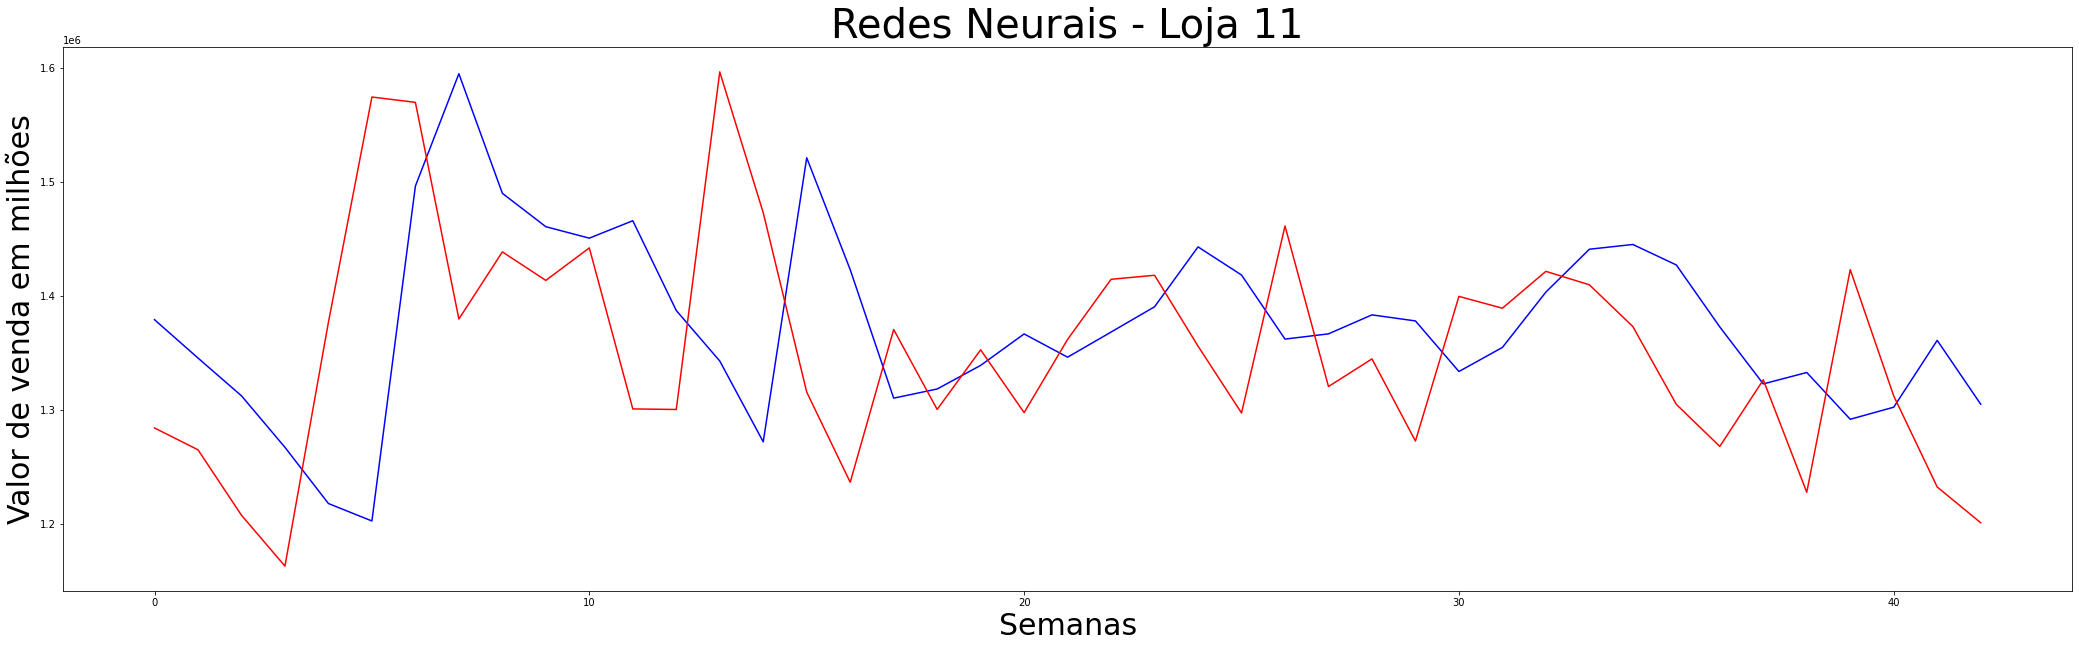

**************************************************
Resultados Loja 12:
66936.65 93533.4


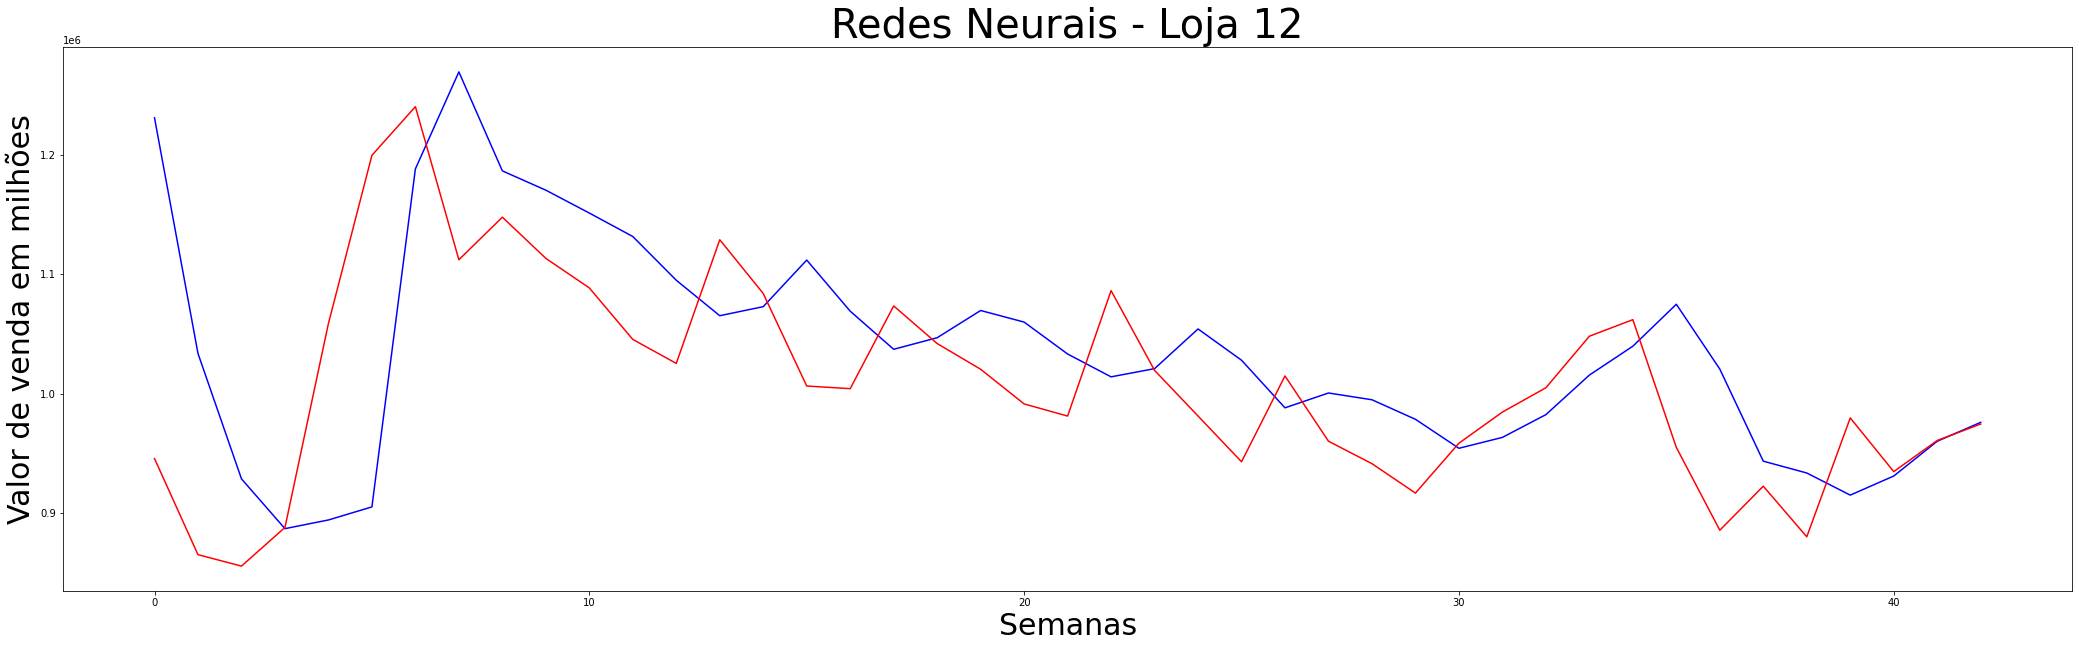

**************************************************
Resultados Loja 13:
89795.79 111150.81


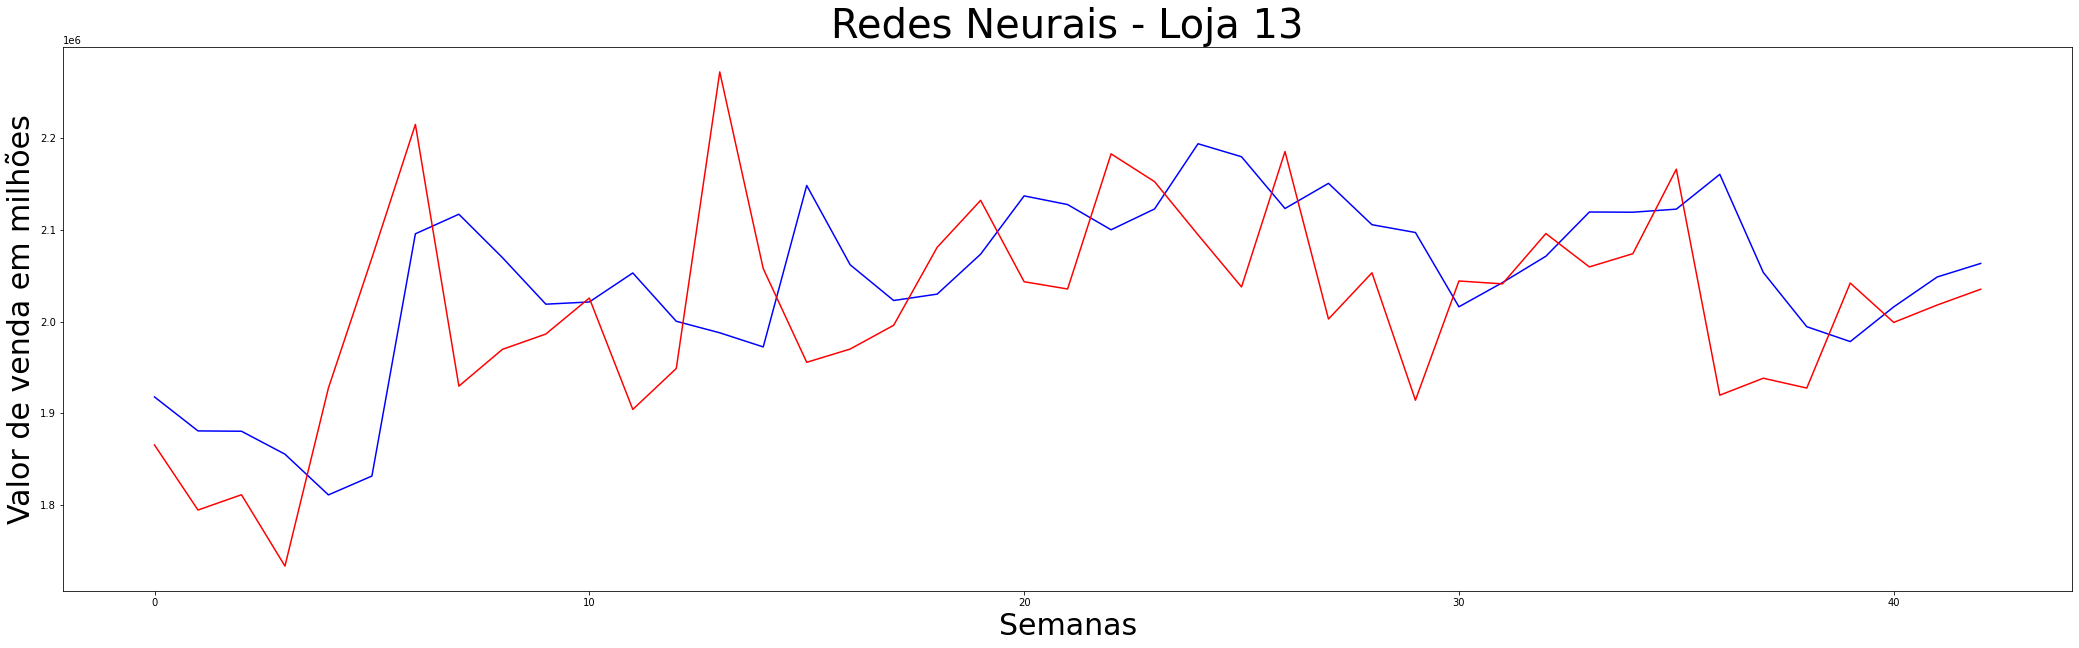

**************************************************
Resultados Loja 14:
126291.93 158654.84


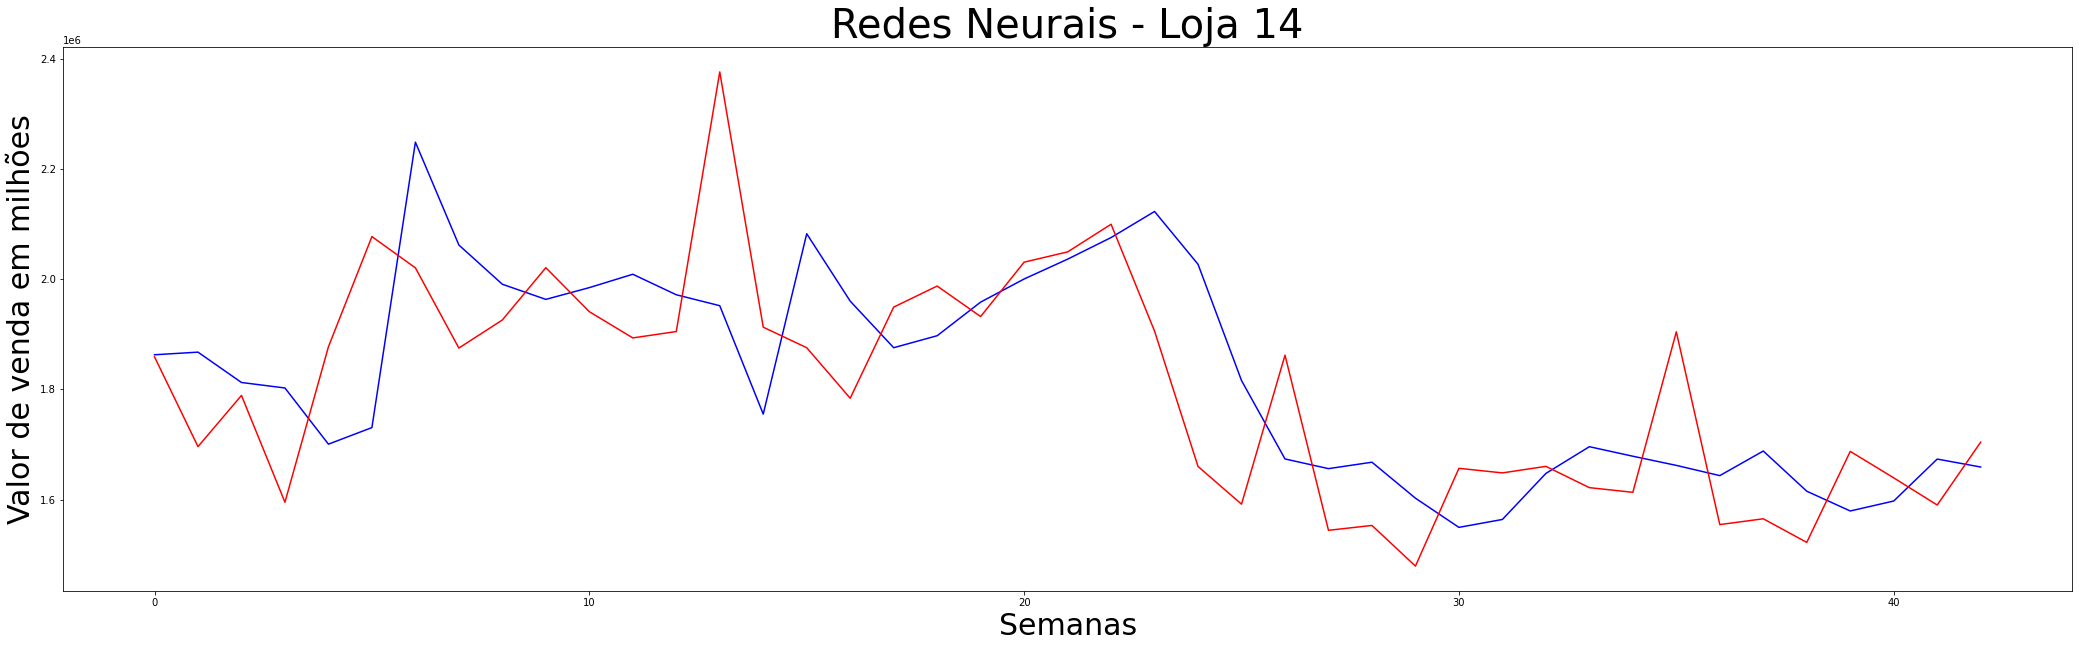

**************************************************
Resultados Loja 15:
38164.78 49545.87


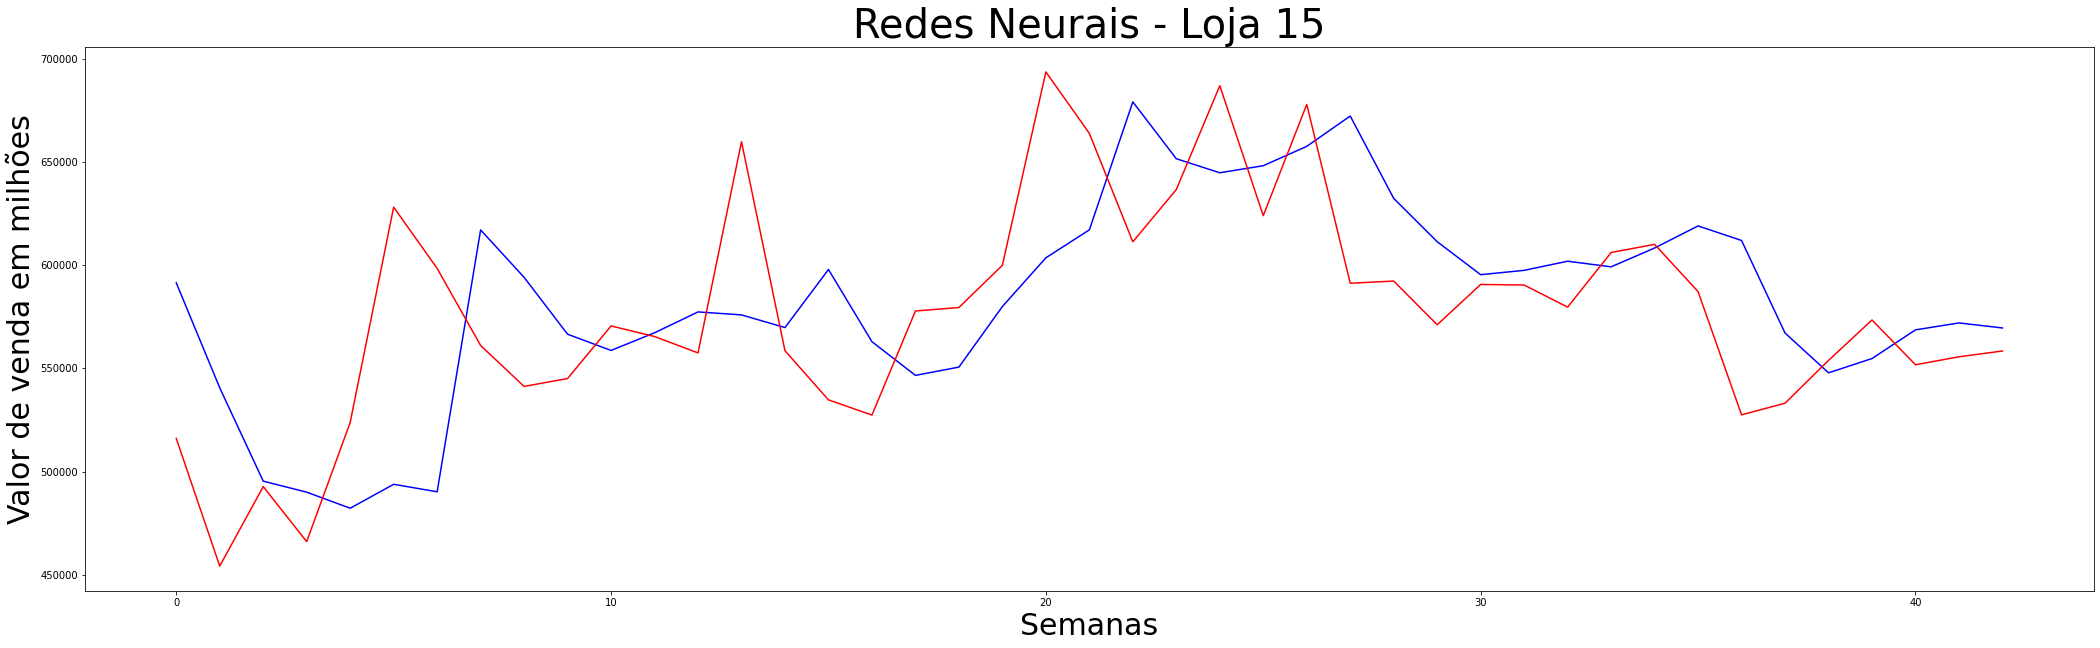

**************************************************
Resultados Loja 16:
35191.387 47957.02


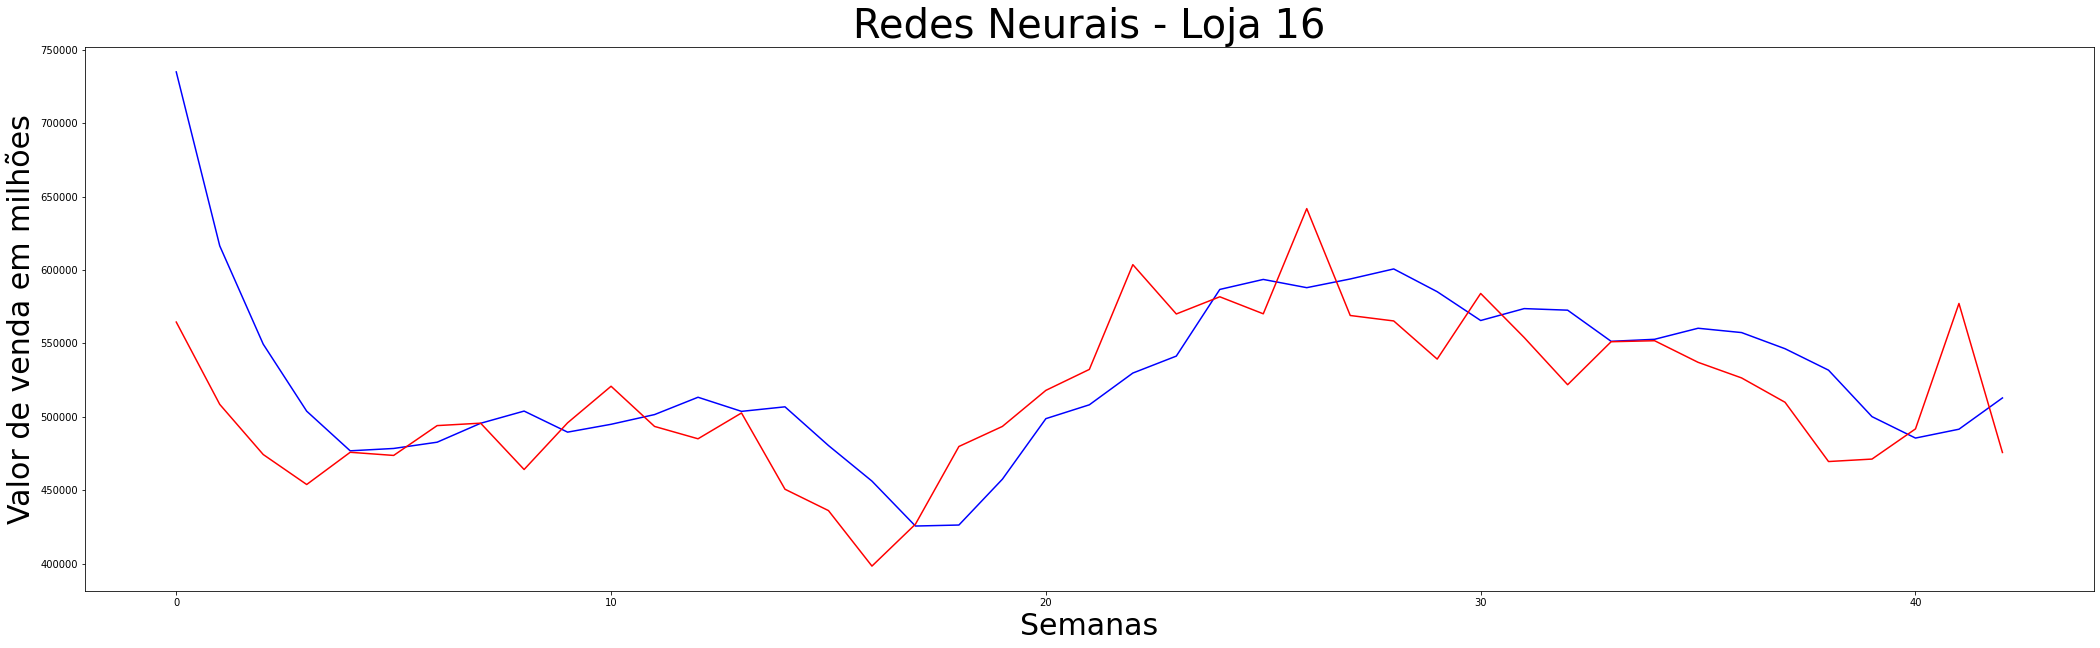

**************************************************
Resultados Loja 17:
72998.805 113514.59


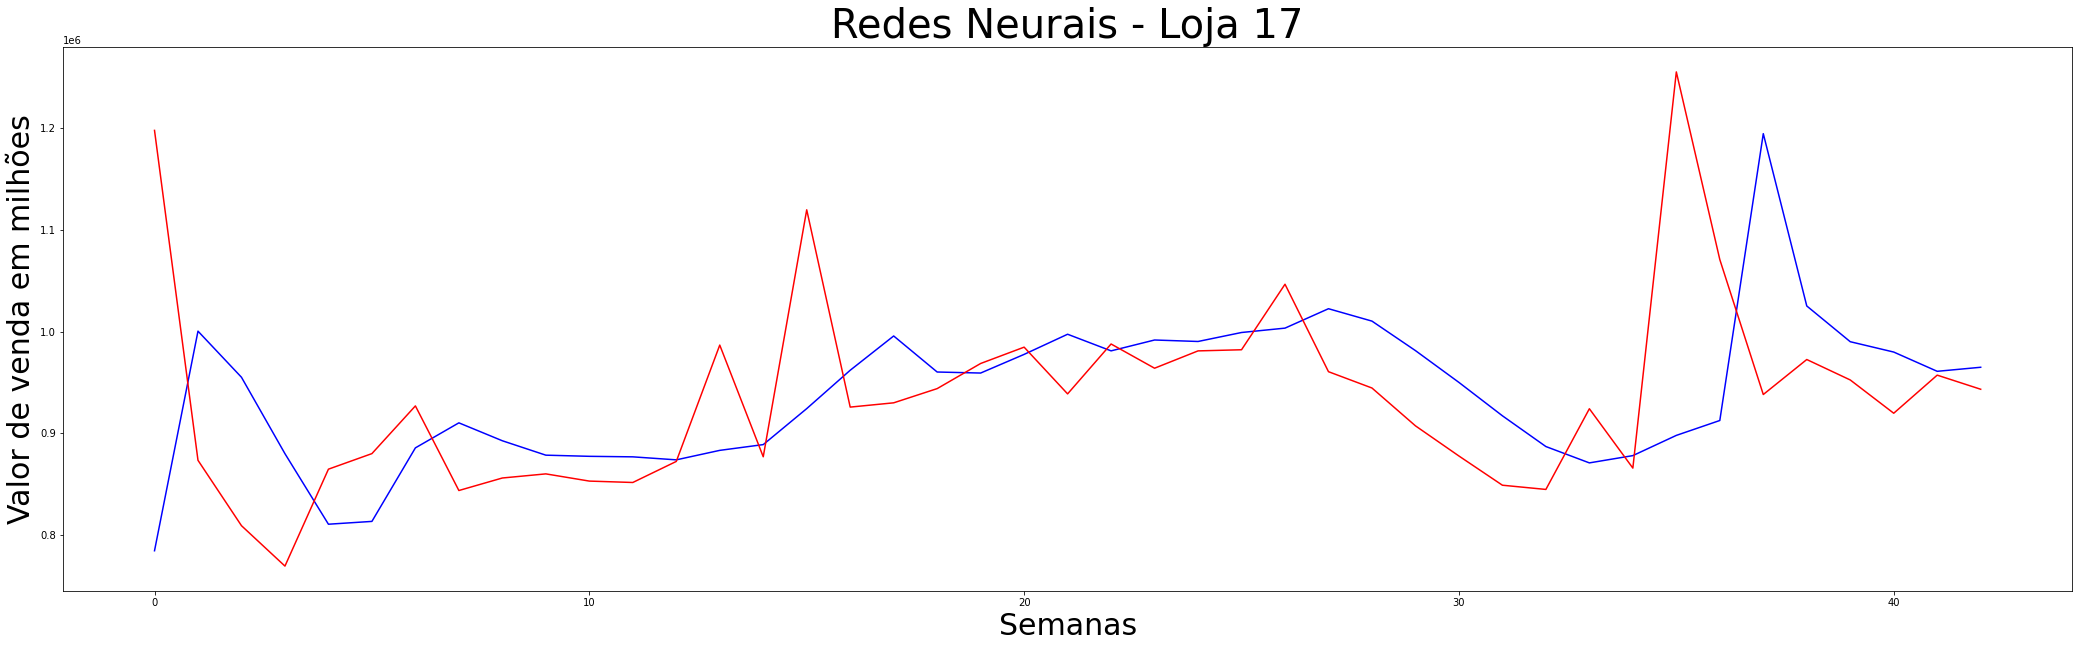

**************************************************
Resultados Loja 18:
63069.848 81612.29


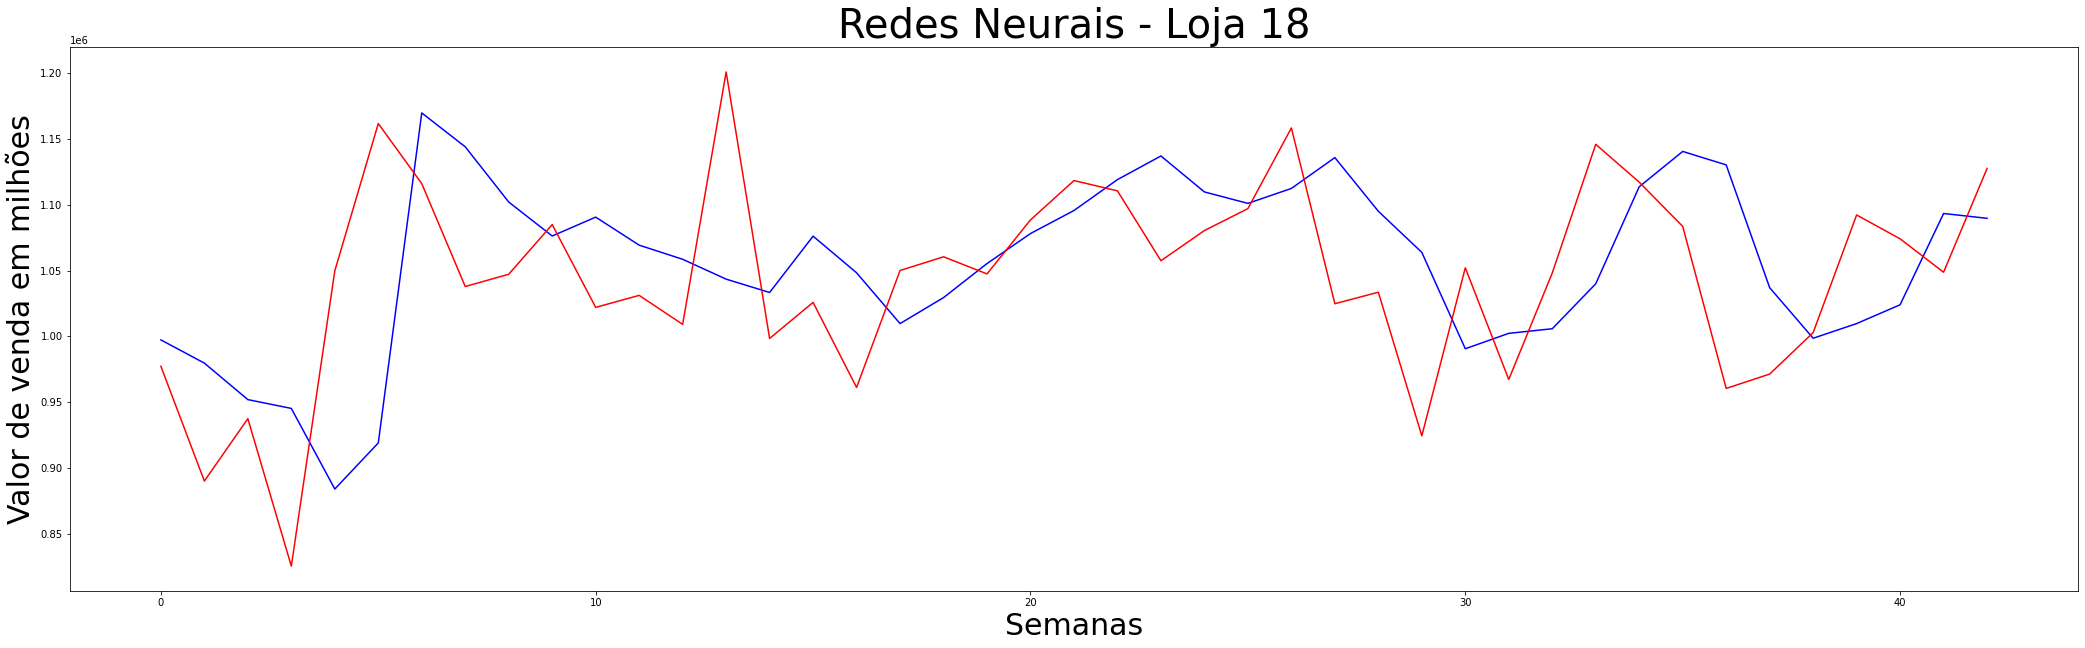

**************************************************
Resultados Loja 19:
81405.08 99671.16


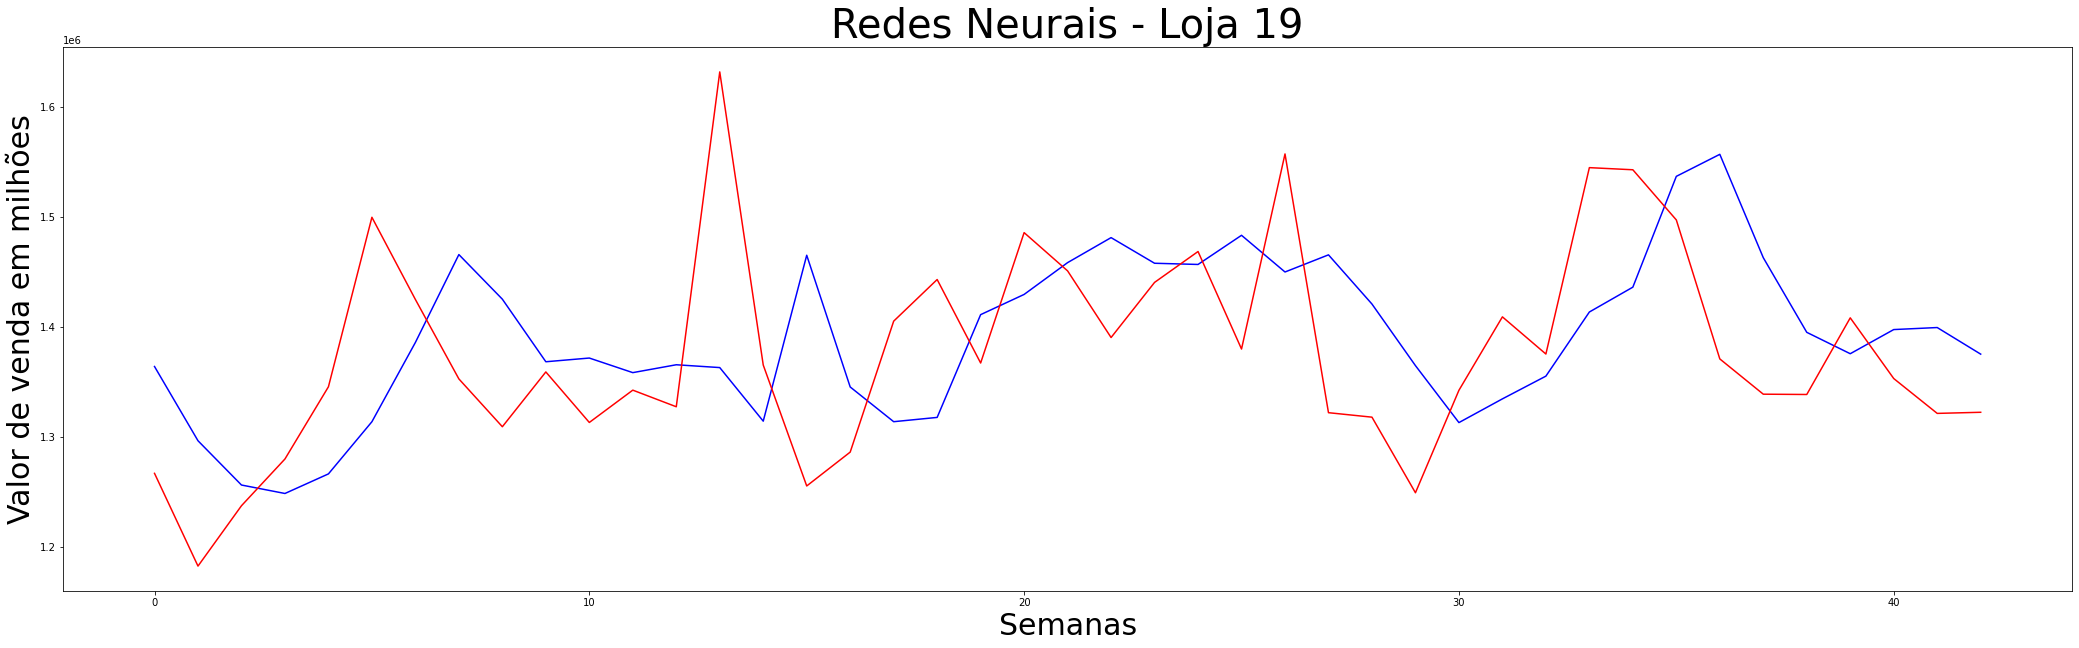

**************************************************
Resultados Loja 20:
148559.6 194778.05


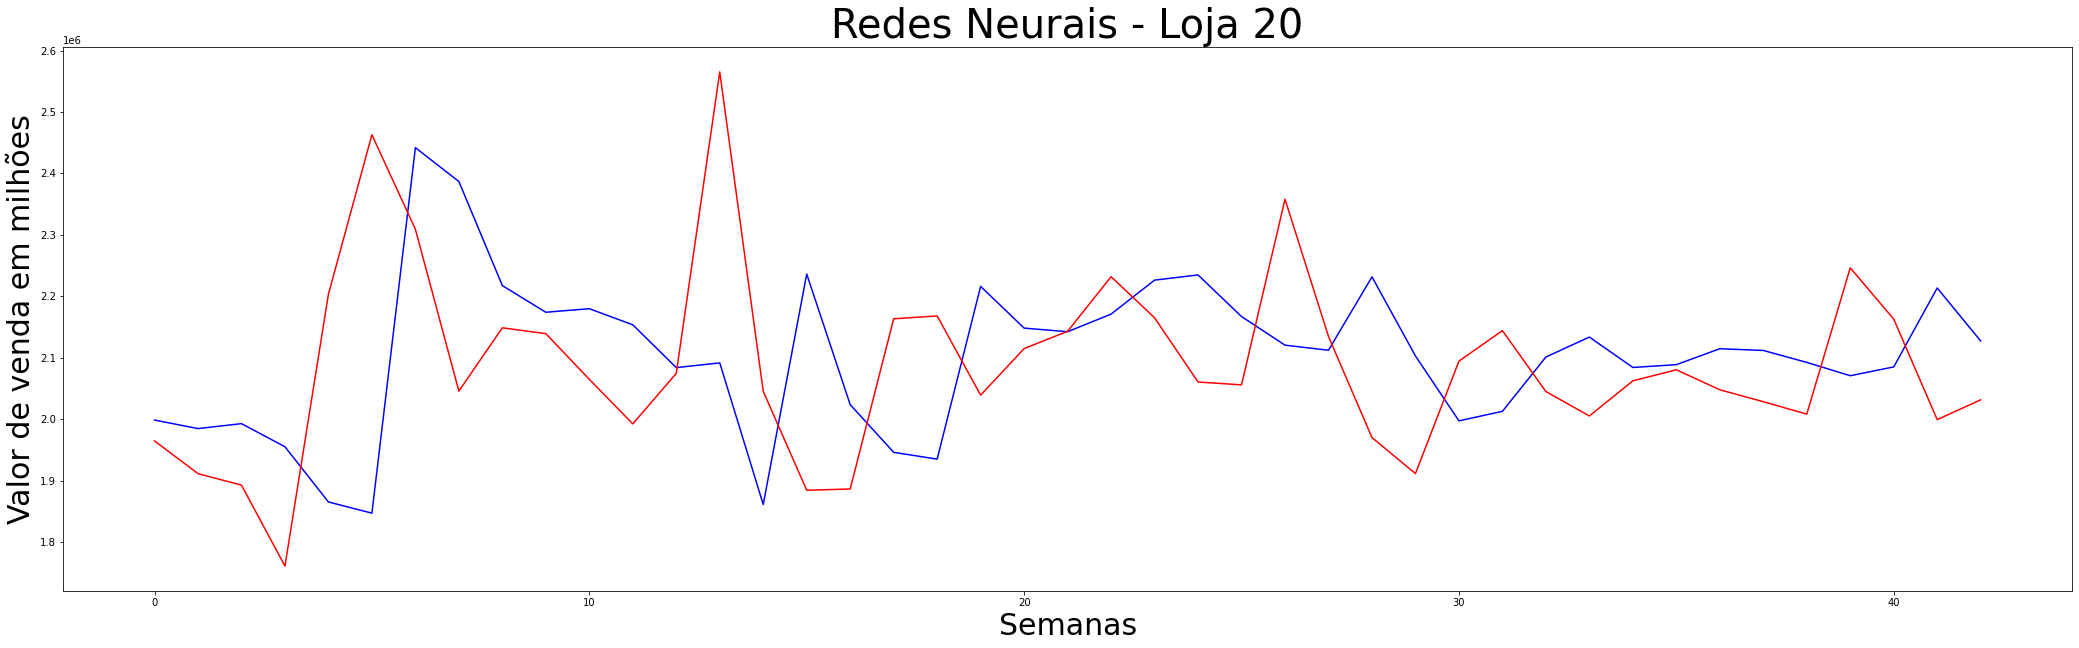

**************************************************
Resultados Loja 21:
39073.75 54787.78


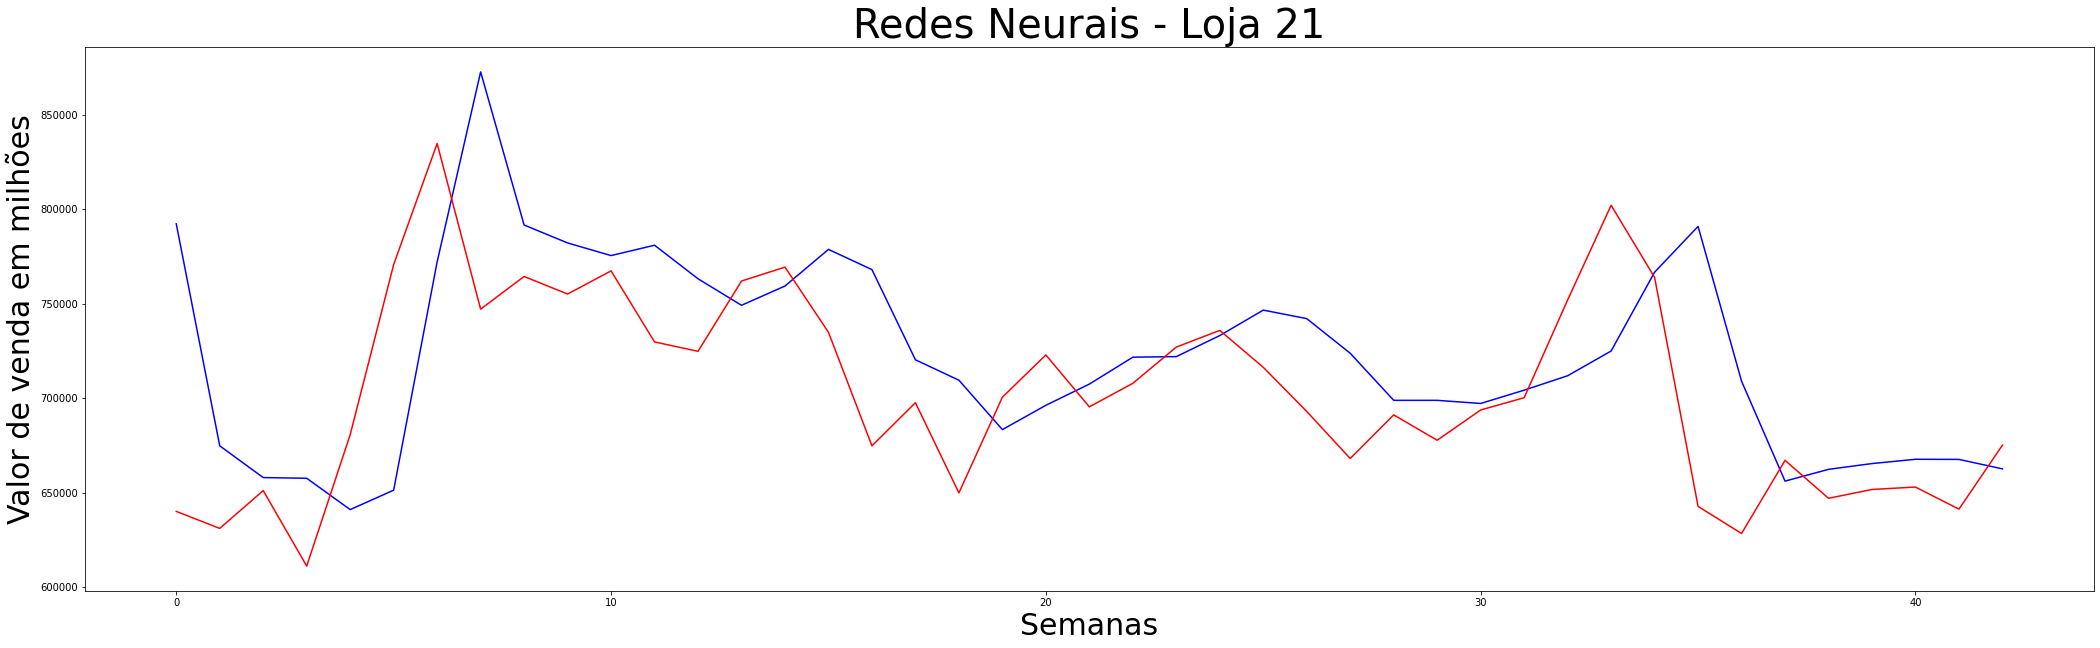

**************************************************
Resultados Loja 22:
55260.027 73631.71


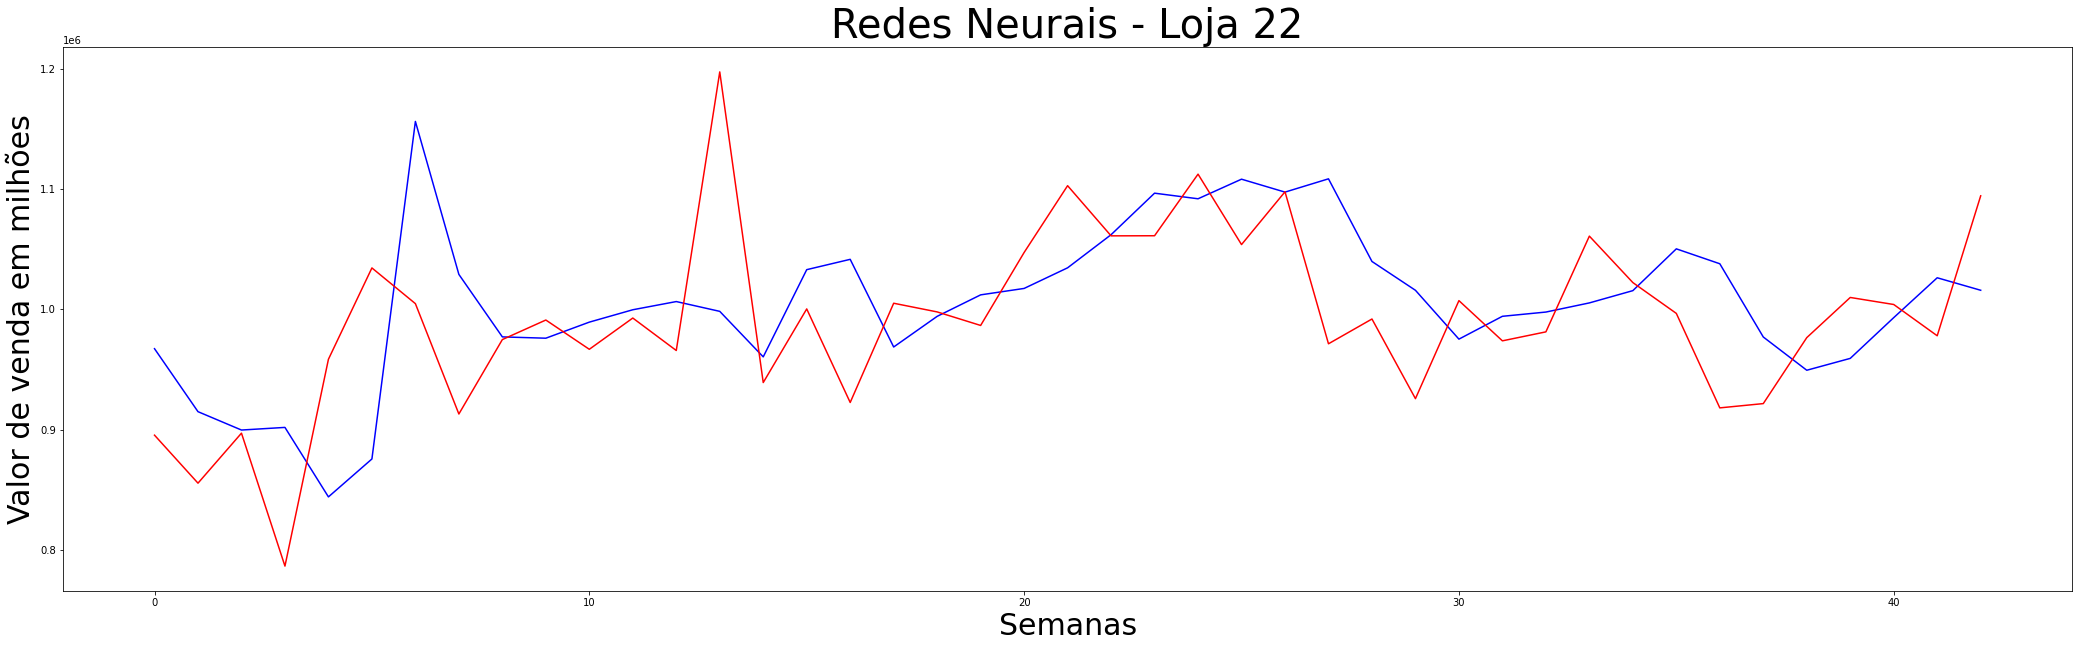

**************************************************
Resultados Loja 23:
91672.734 116914.95


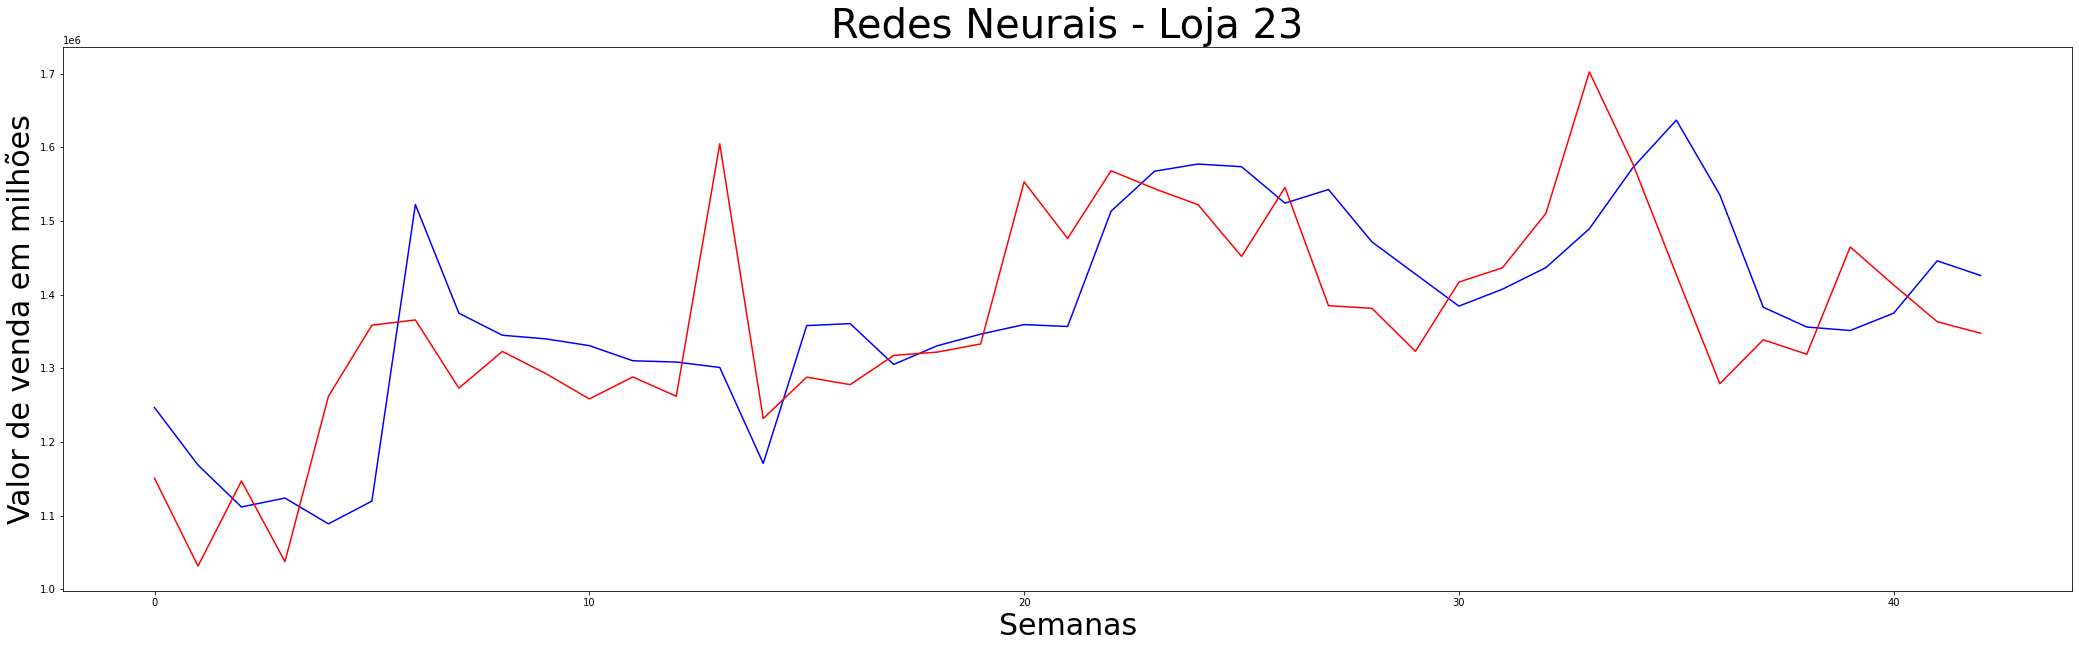

**************************************************
Resultados Loja 24:
102552.555 119312.13


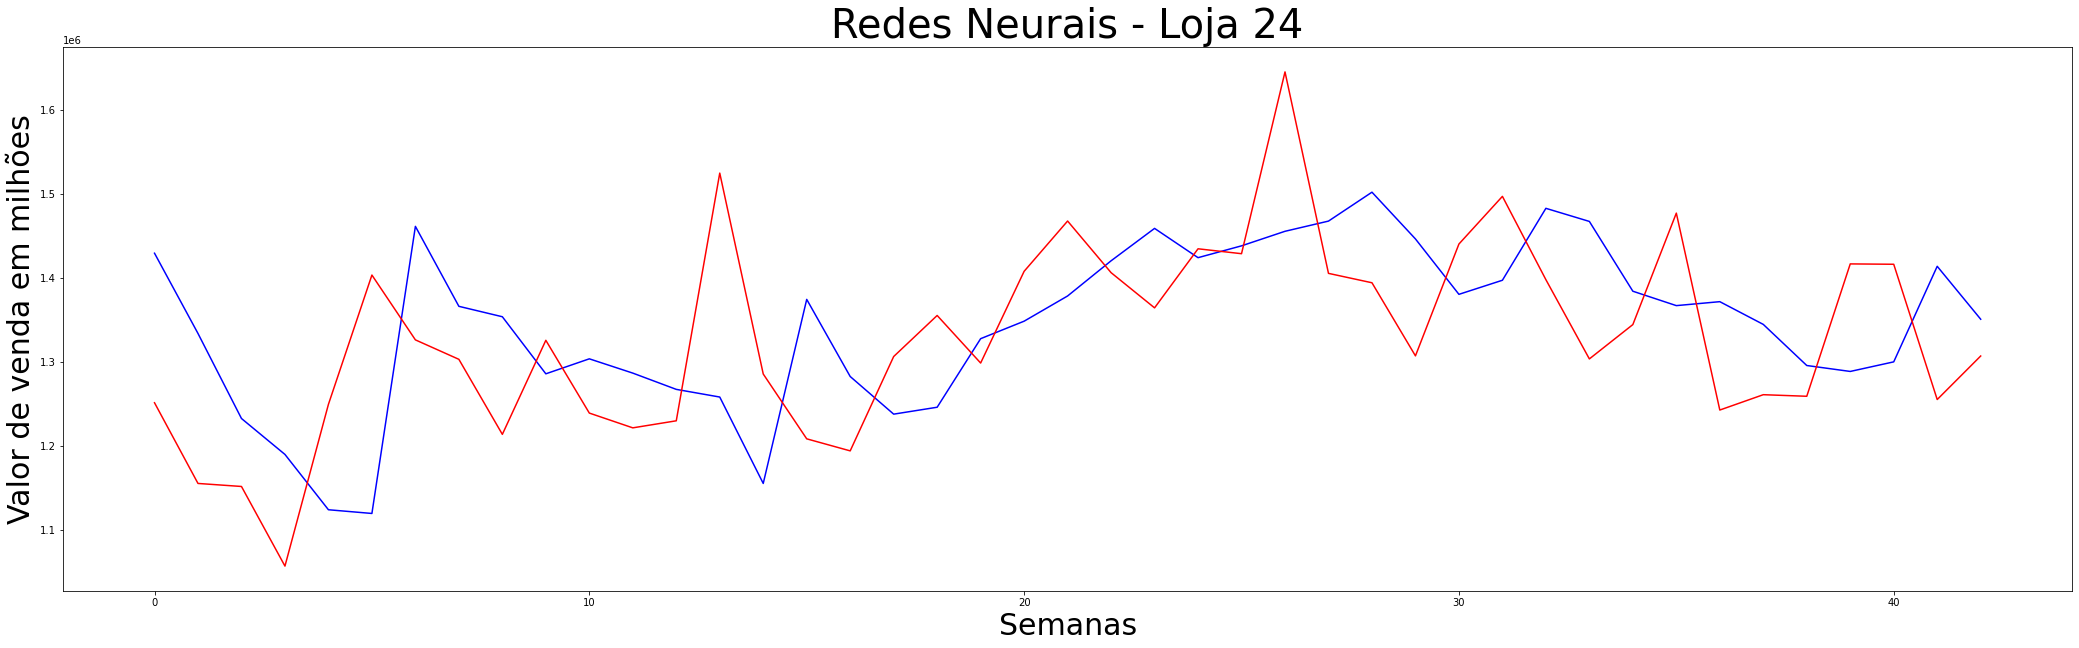

**************************************************
Resultados Loja 25:
30684.18 37451.793


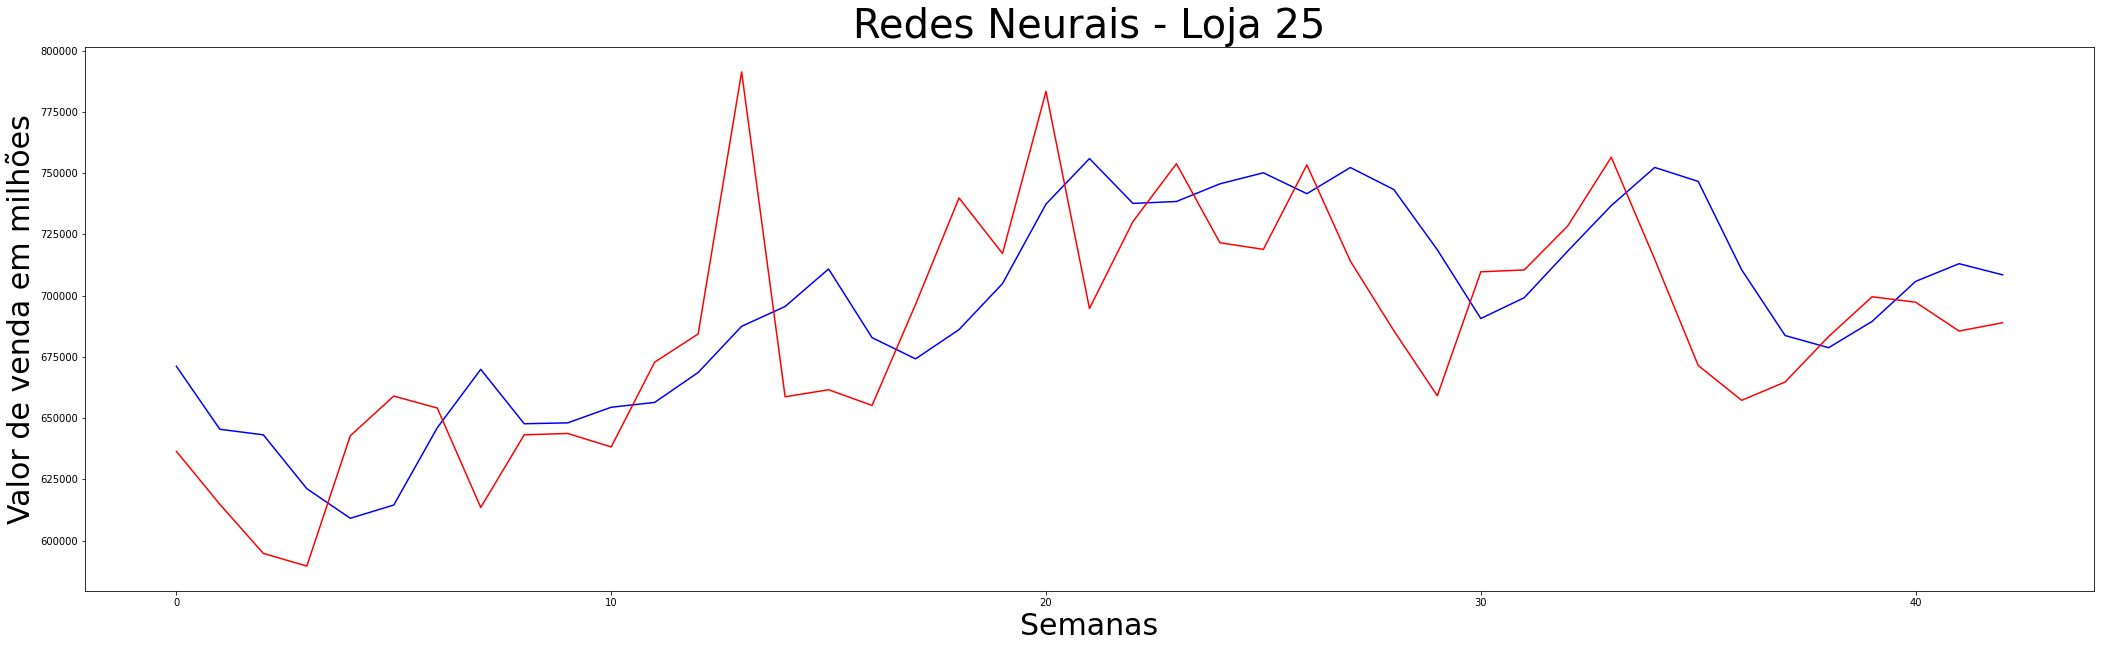

**************************************************
Resultados Loja 26:
65600.11 83470.7


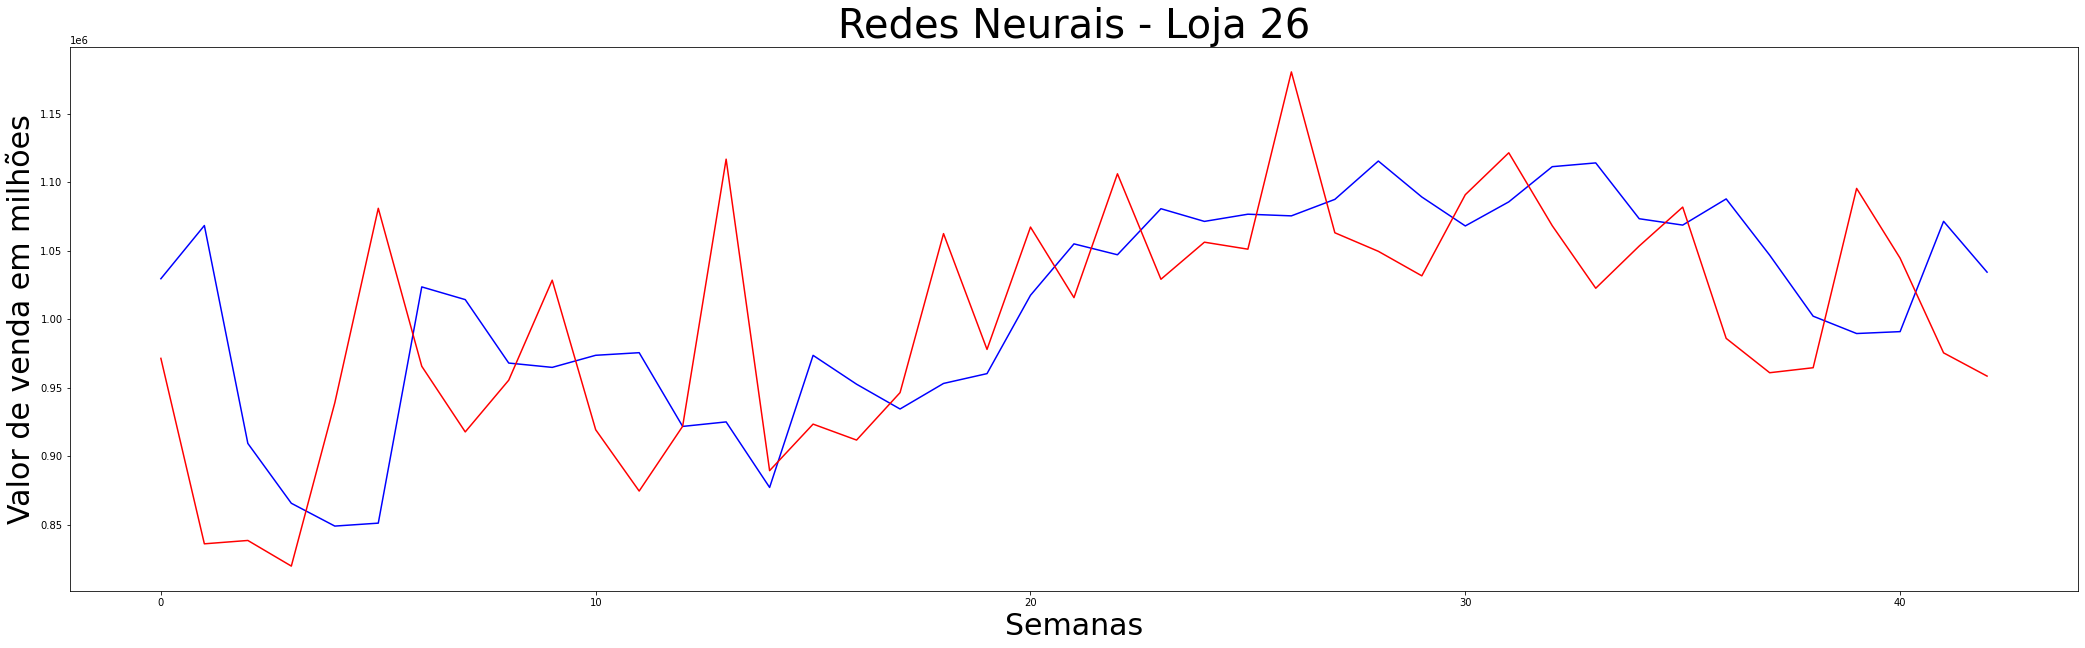

**************************************************
Resultados Loja 27:
86392.805 120564.5


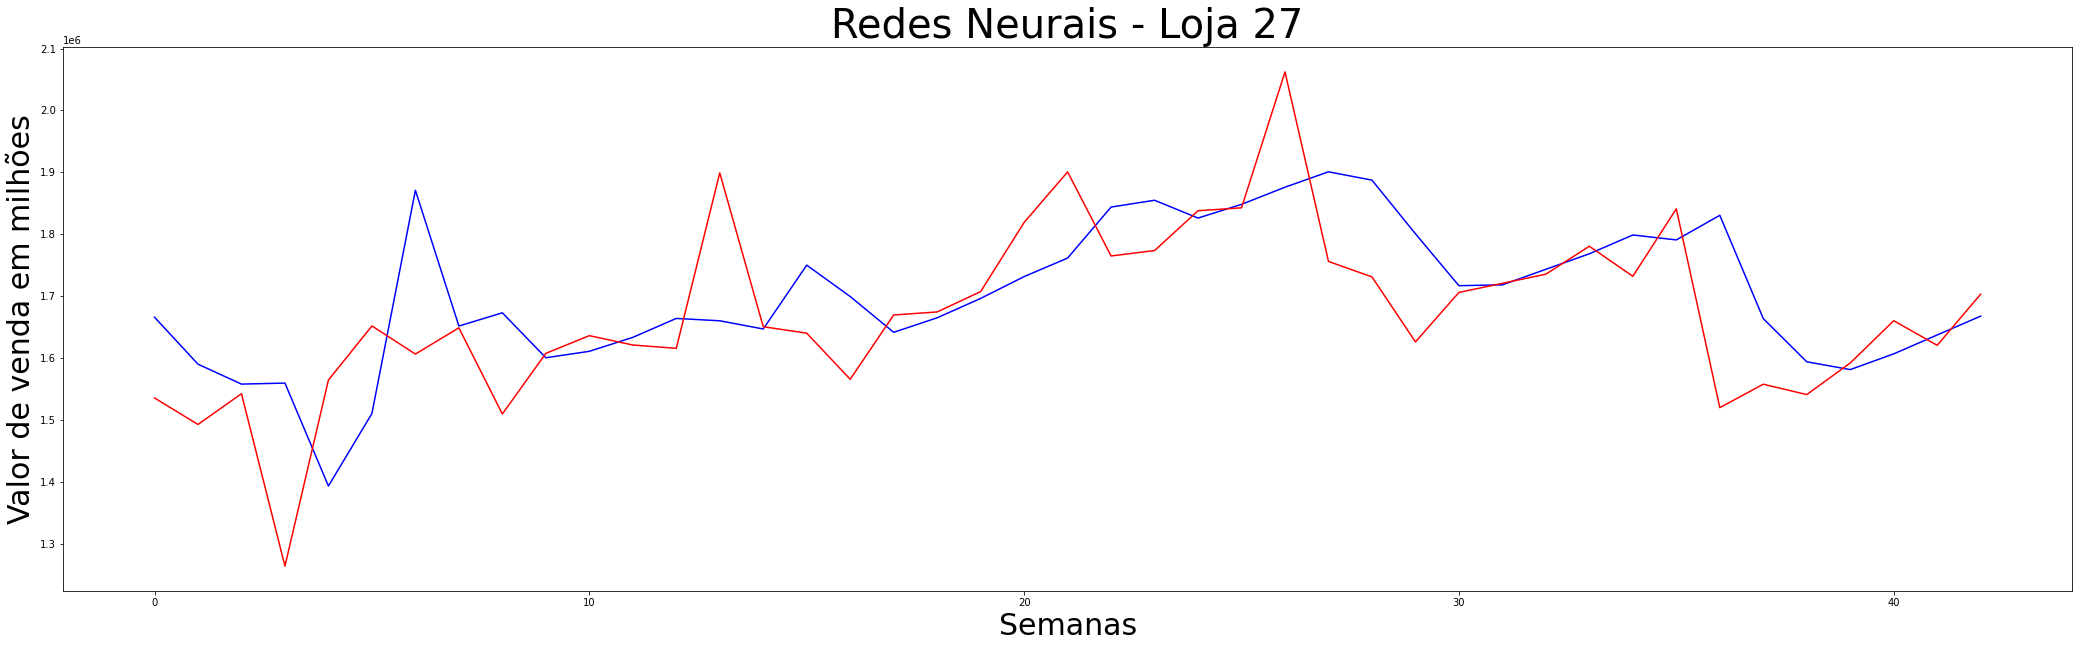

**************************************************
Resultados Loja 28:
173750.14 209749.78


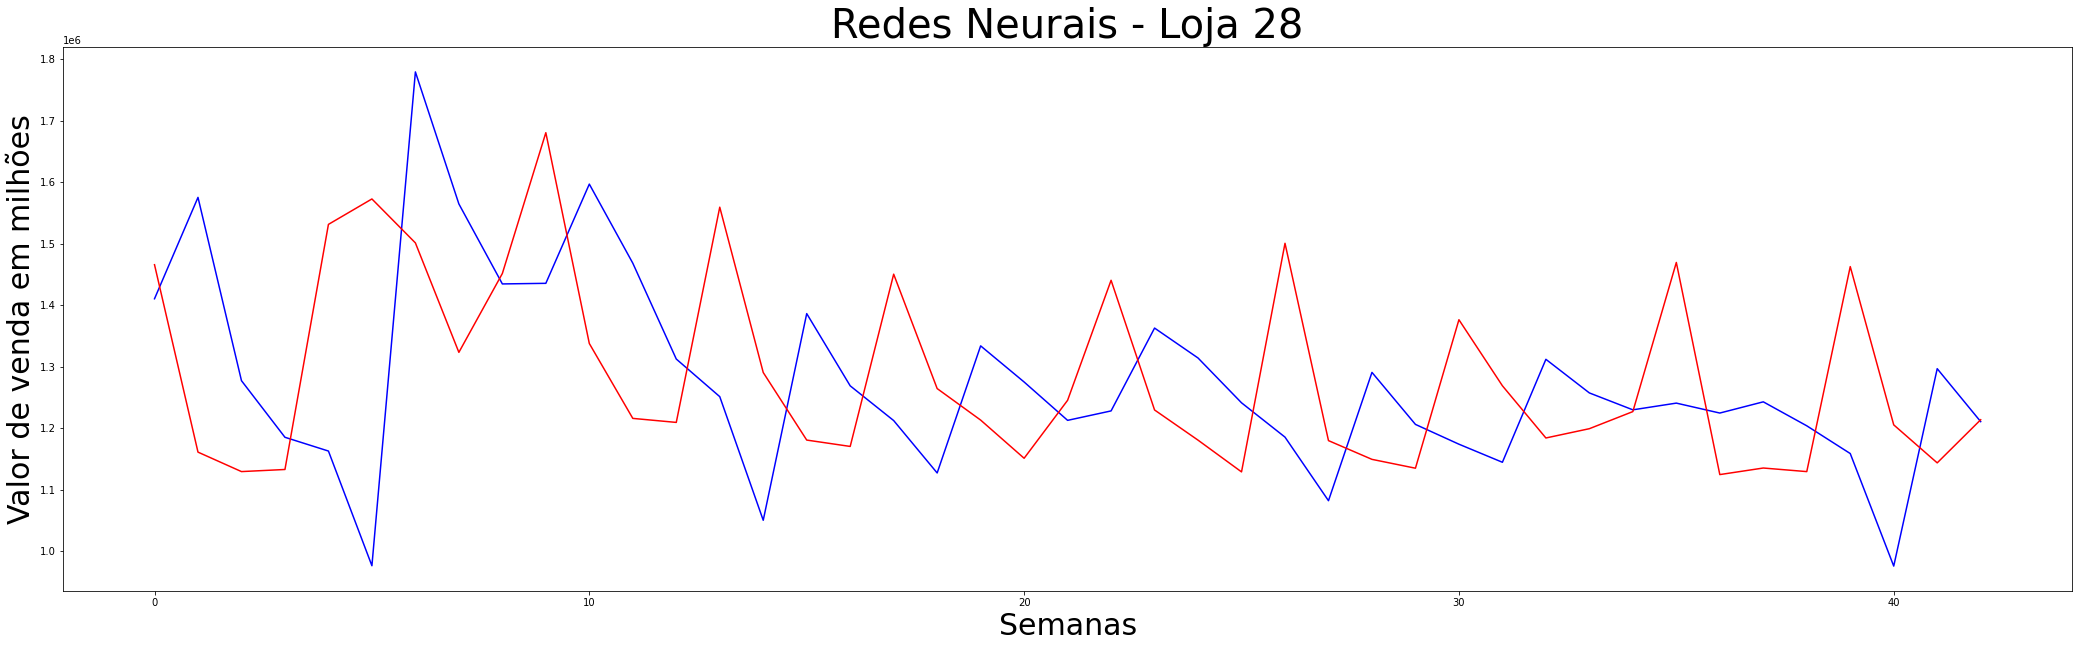

**************************************************
Resultados Loja 29:
38193.777 51747.715


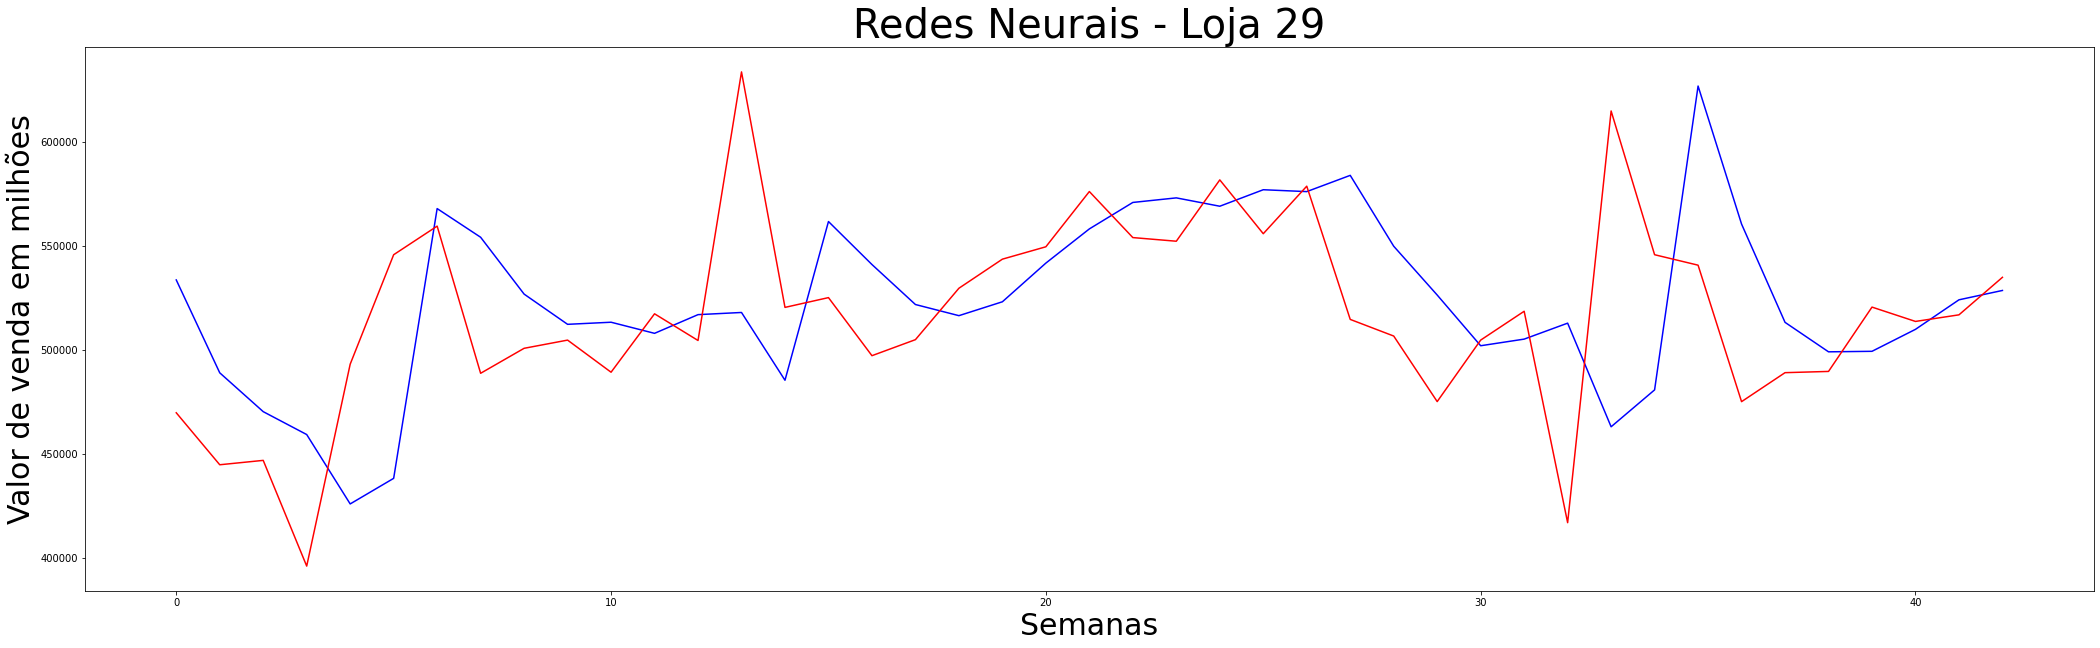

**************************************************
Resultados Loja 30:
14942.325 17999.287


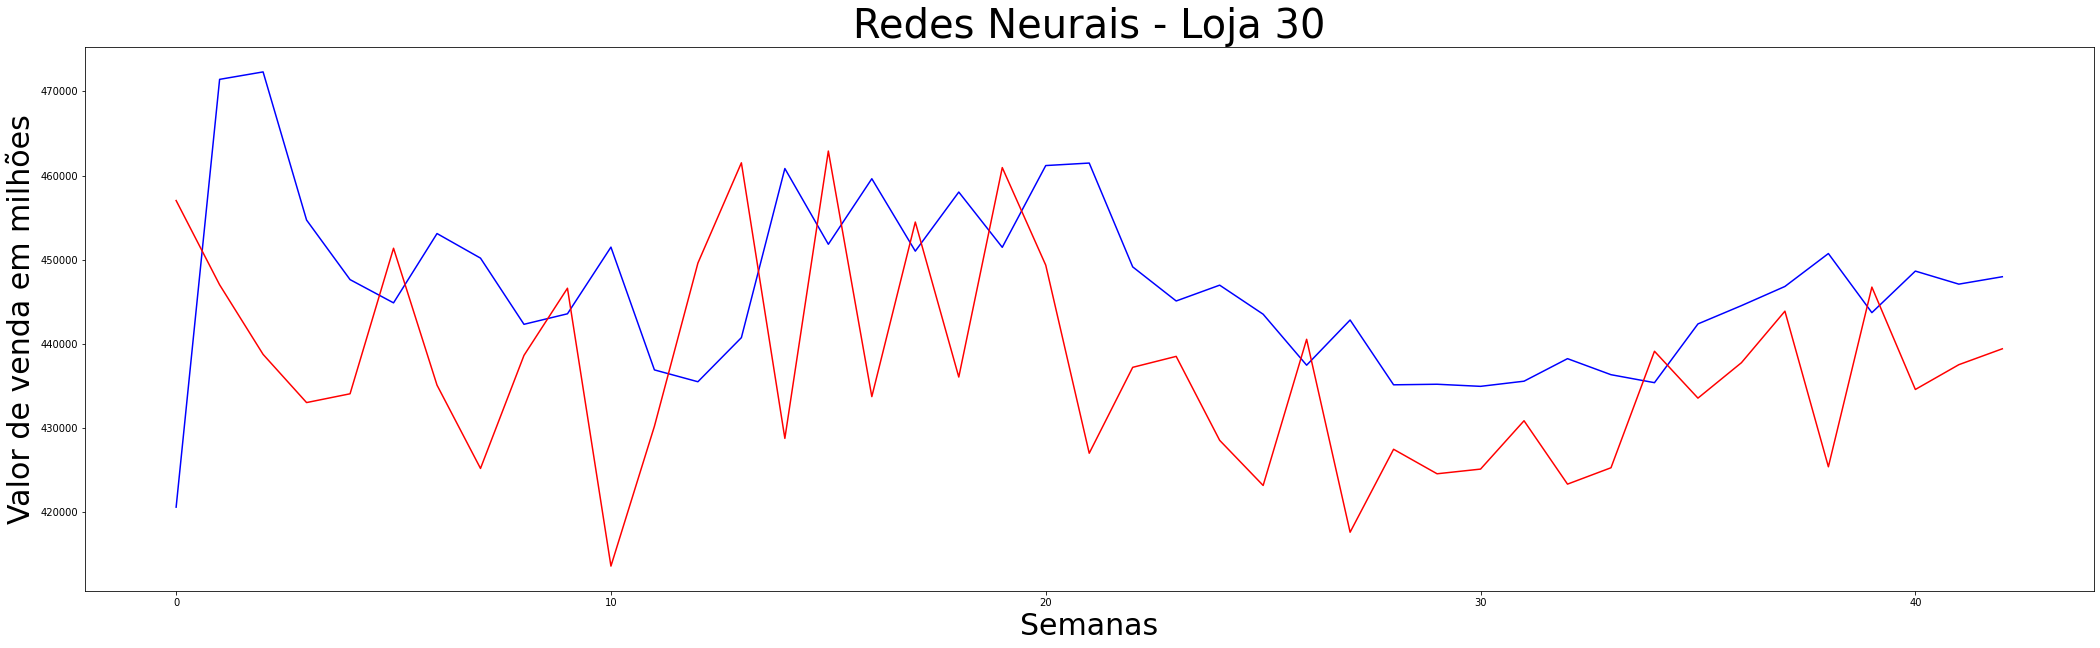

**************************************************
Resultados Loja 31:
61380.14 79175.664


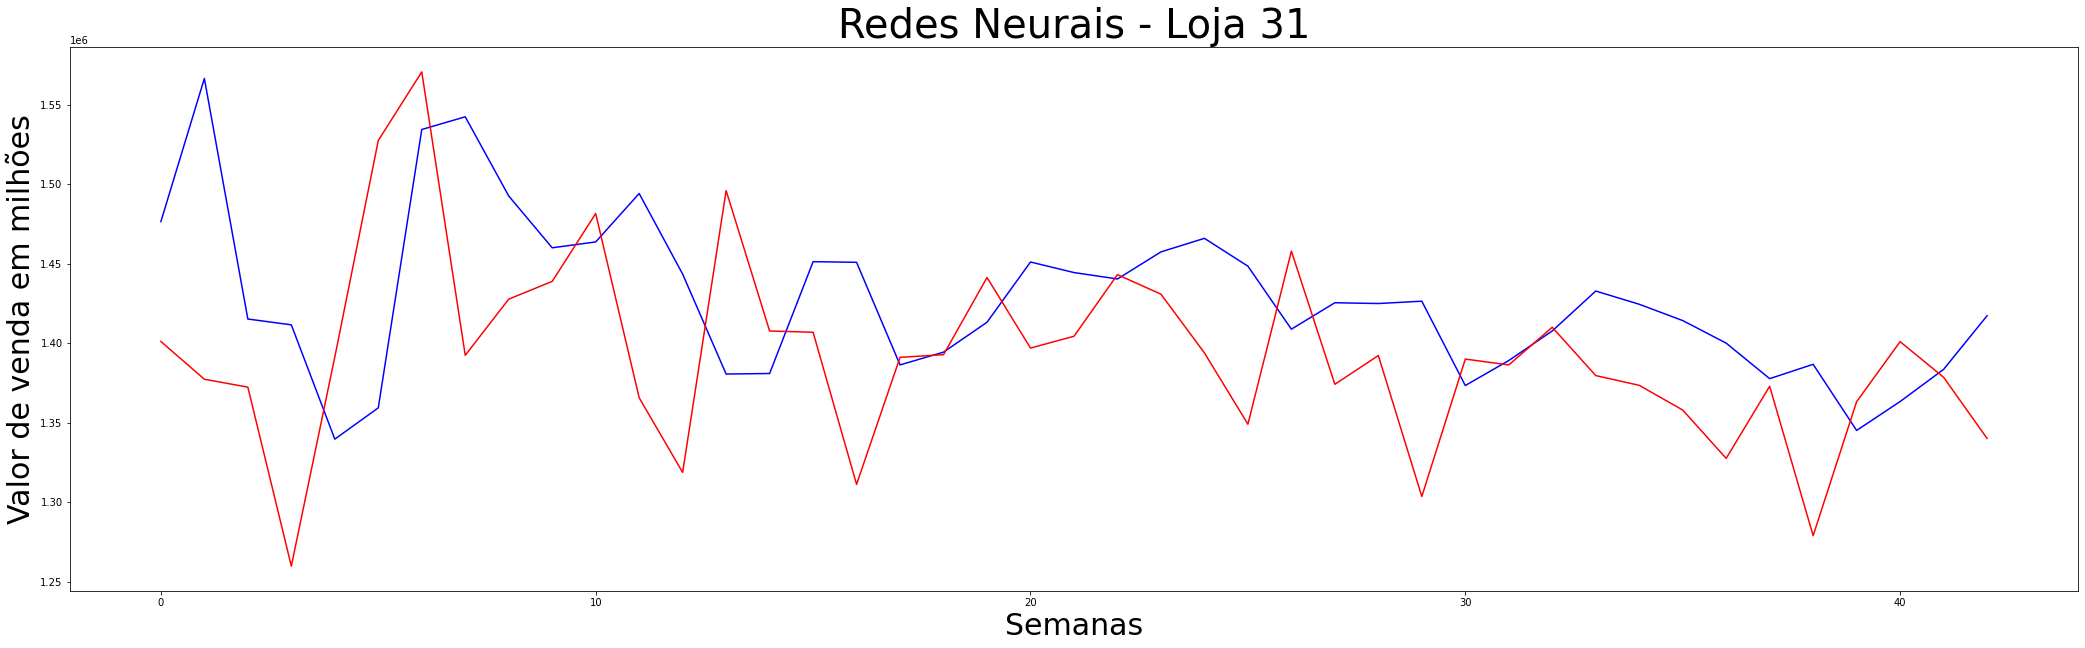

**************************************************
Resultados Loja 32:
41670.746 52955.207


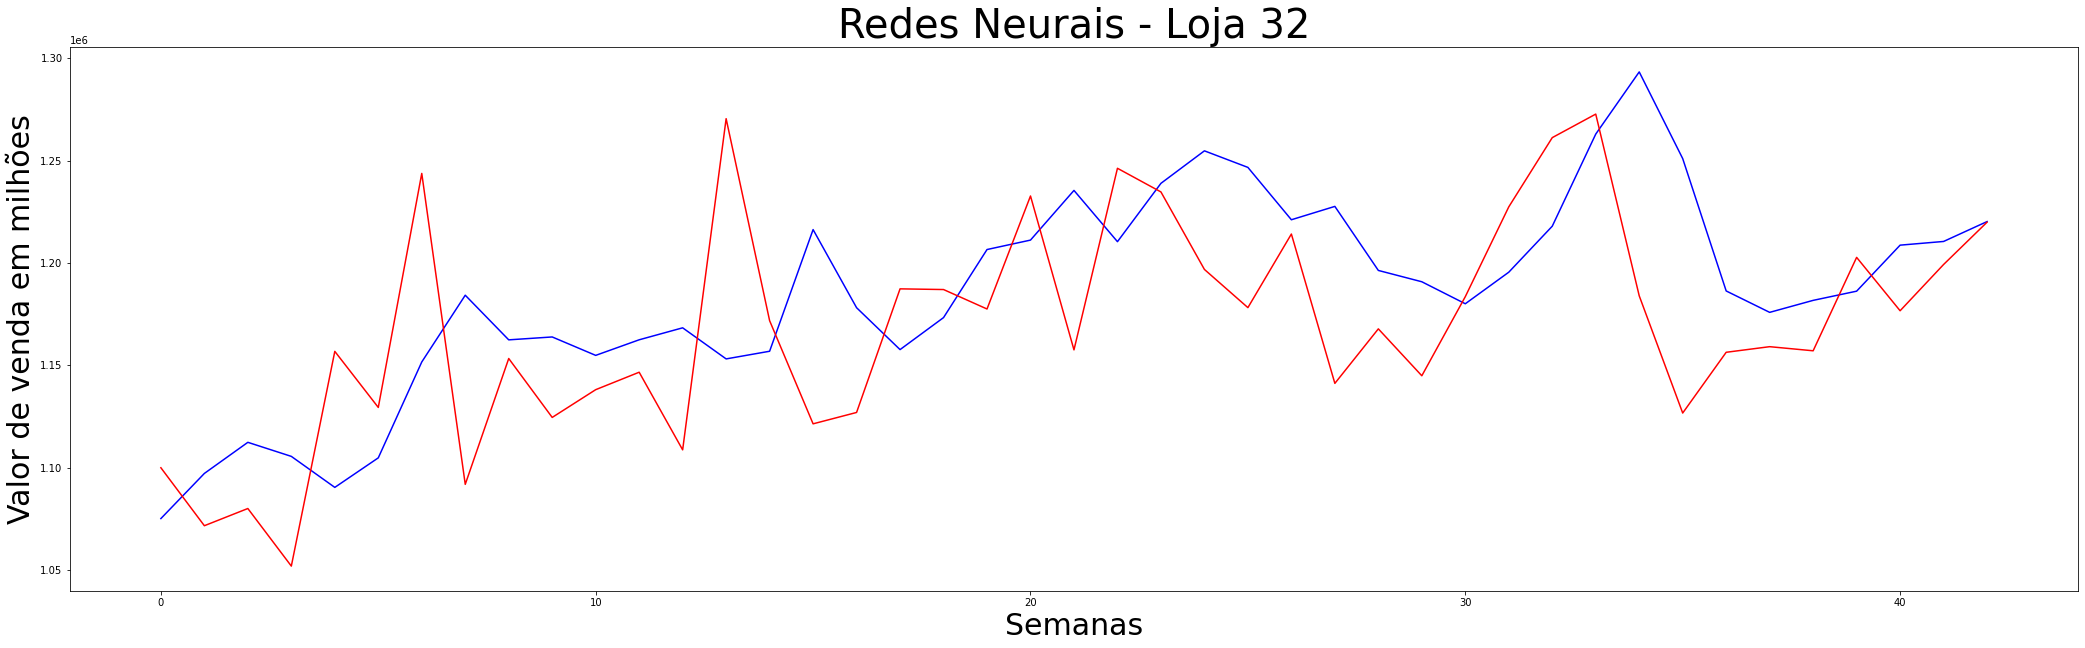

**************************************************
Resultados Loja 33:
26183.838 29458.393


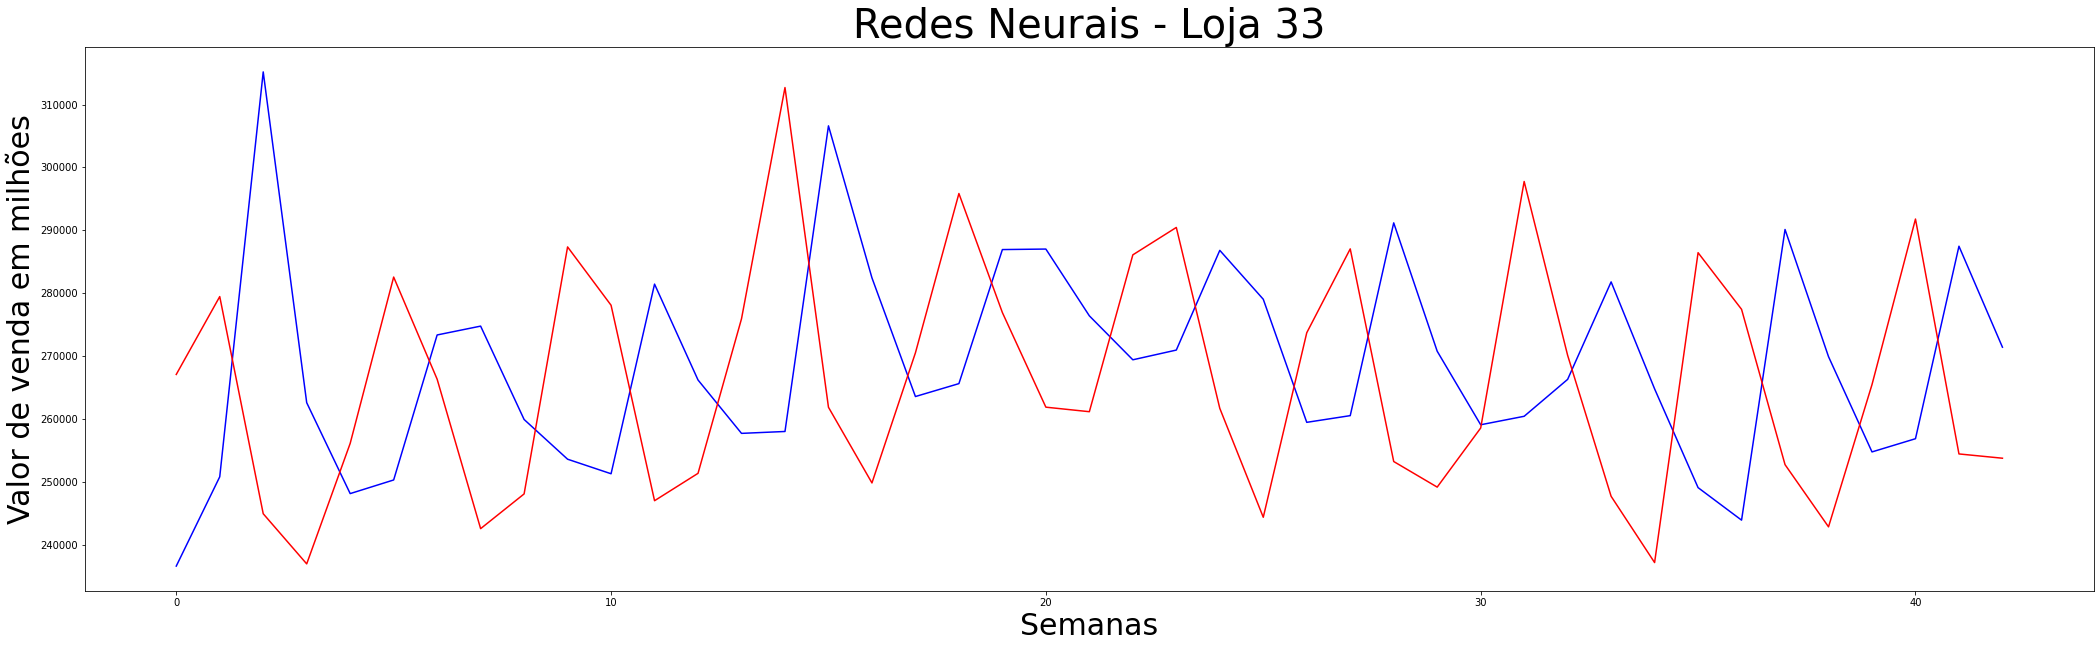

**************************************************
Resultados Loja 34:
46276.152 59762.41


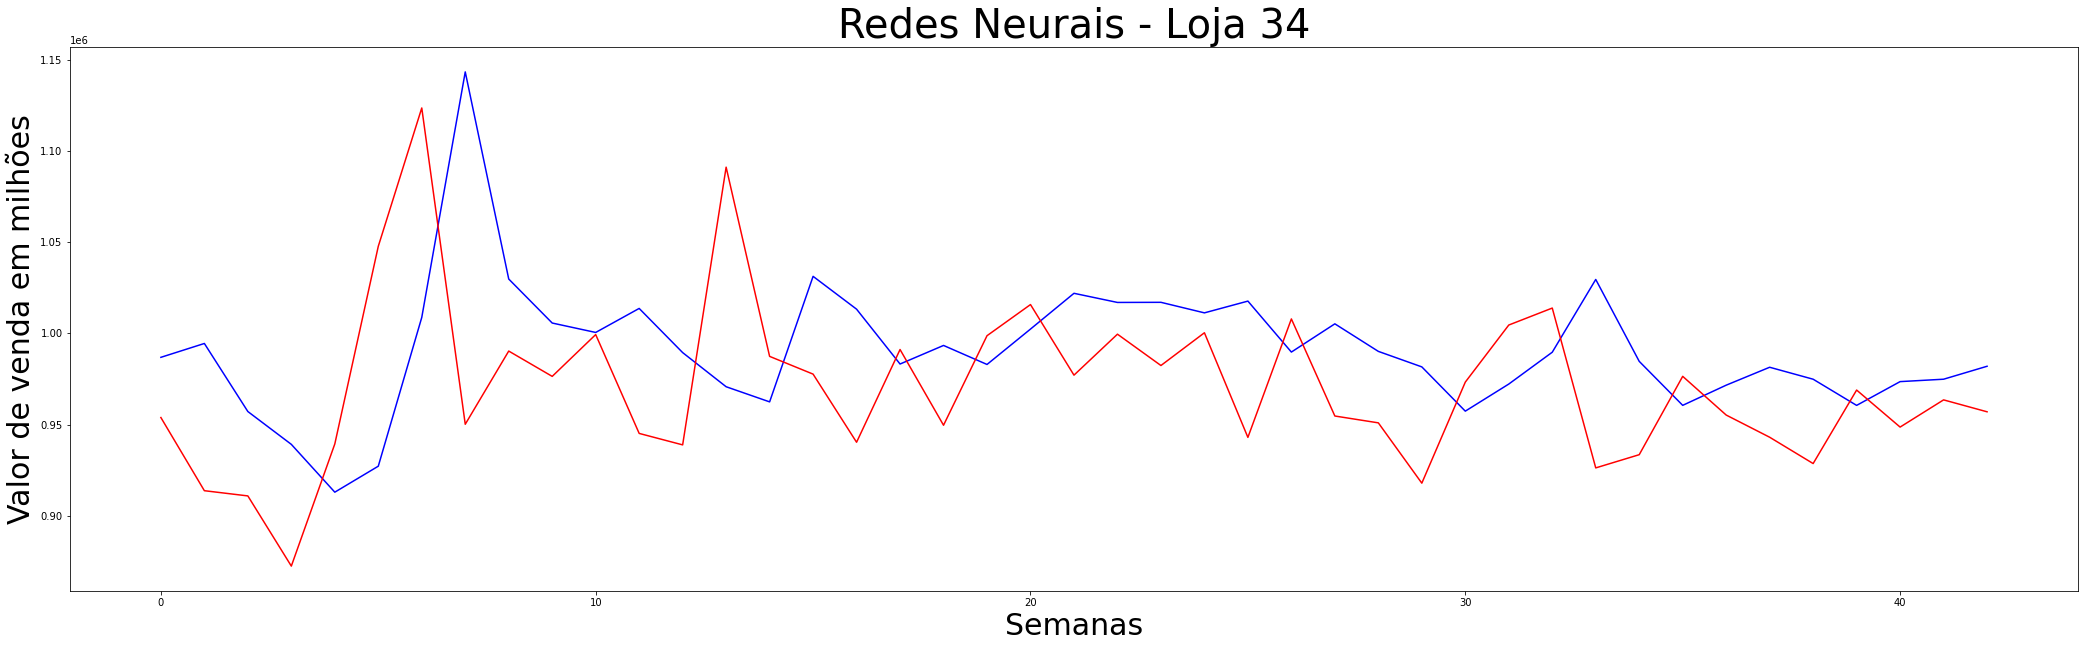

**************************************************
Resultados Loja 35:
54720.844 73444.164


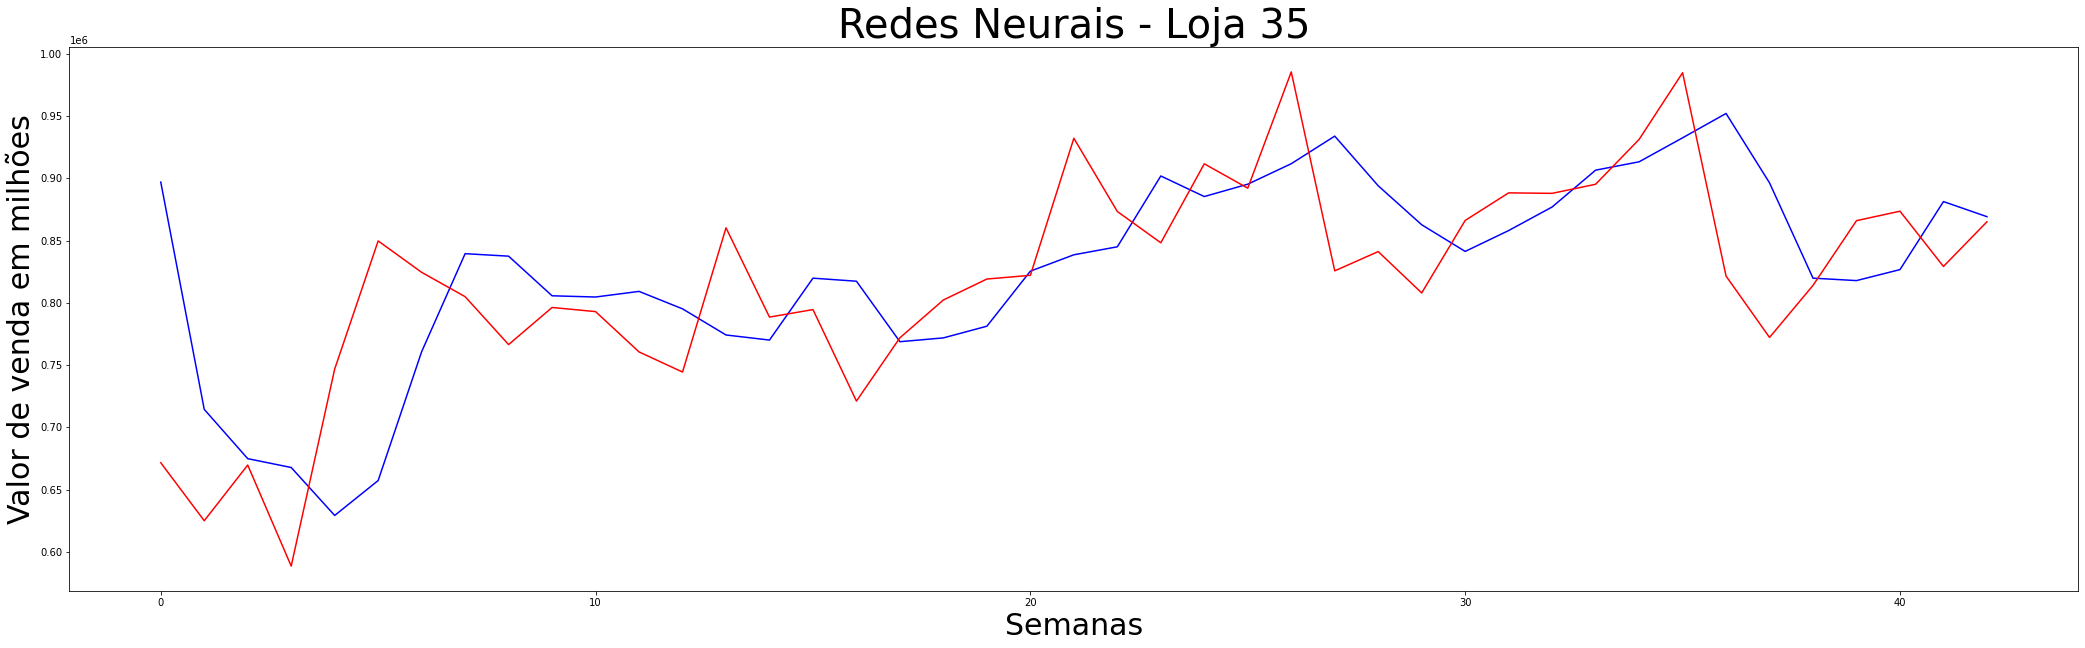

**************************************************
Resultados Loja 36:
15068.191 18035.438


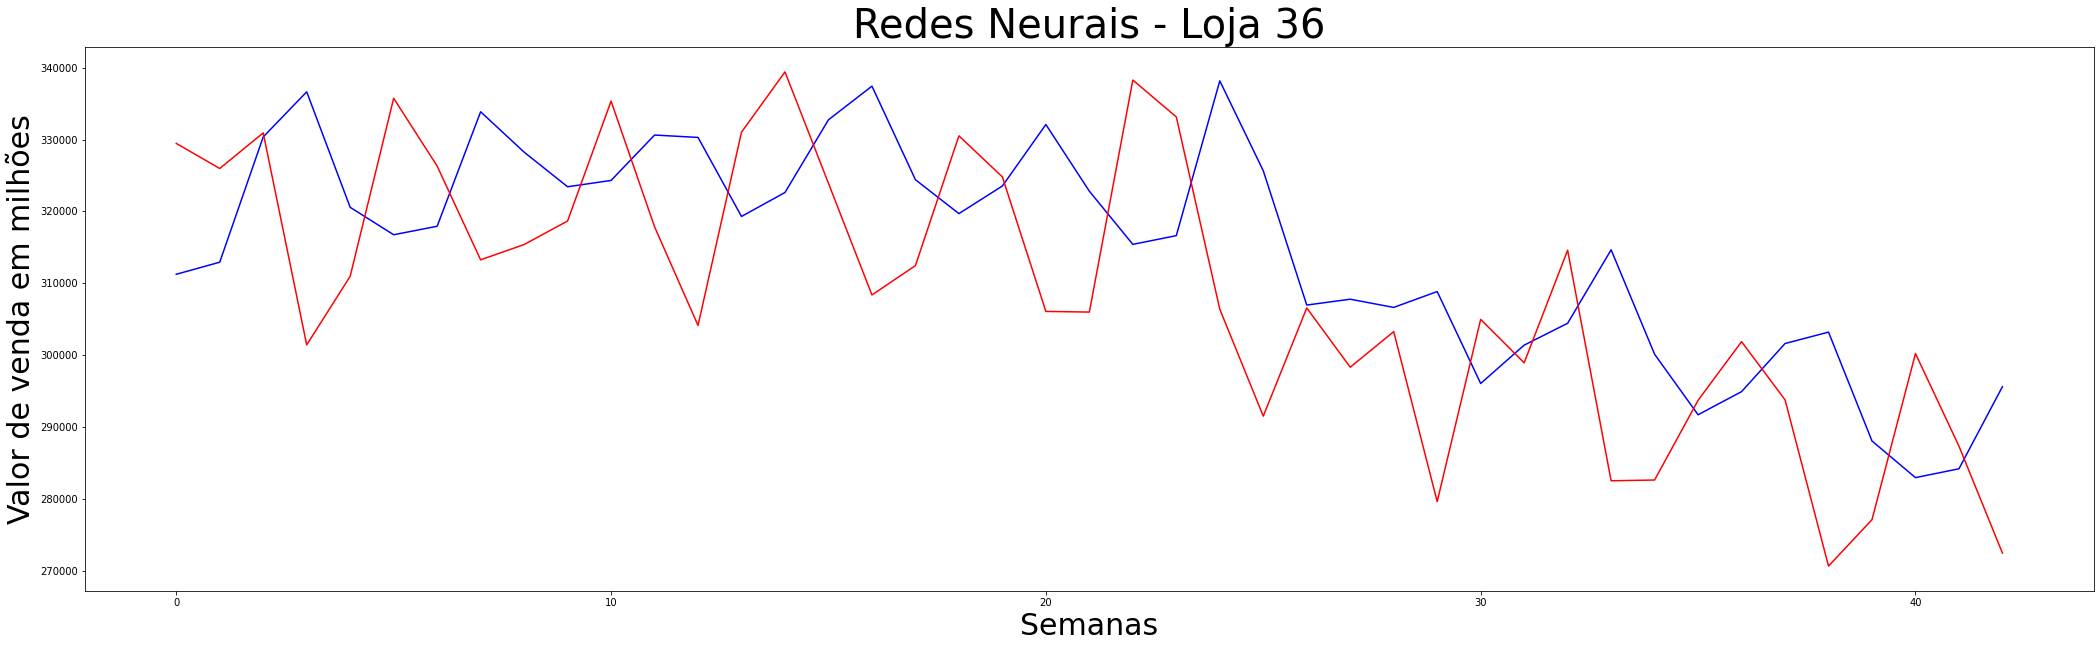

**************************************************
Resultados Loja 37:
18767.854 24167.25


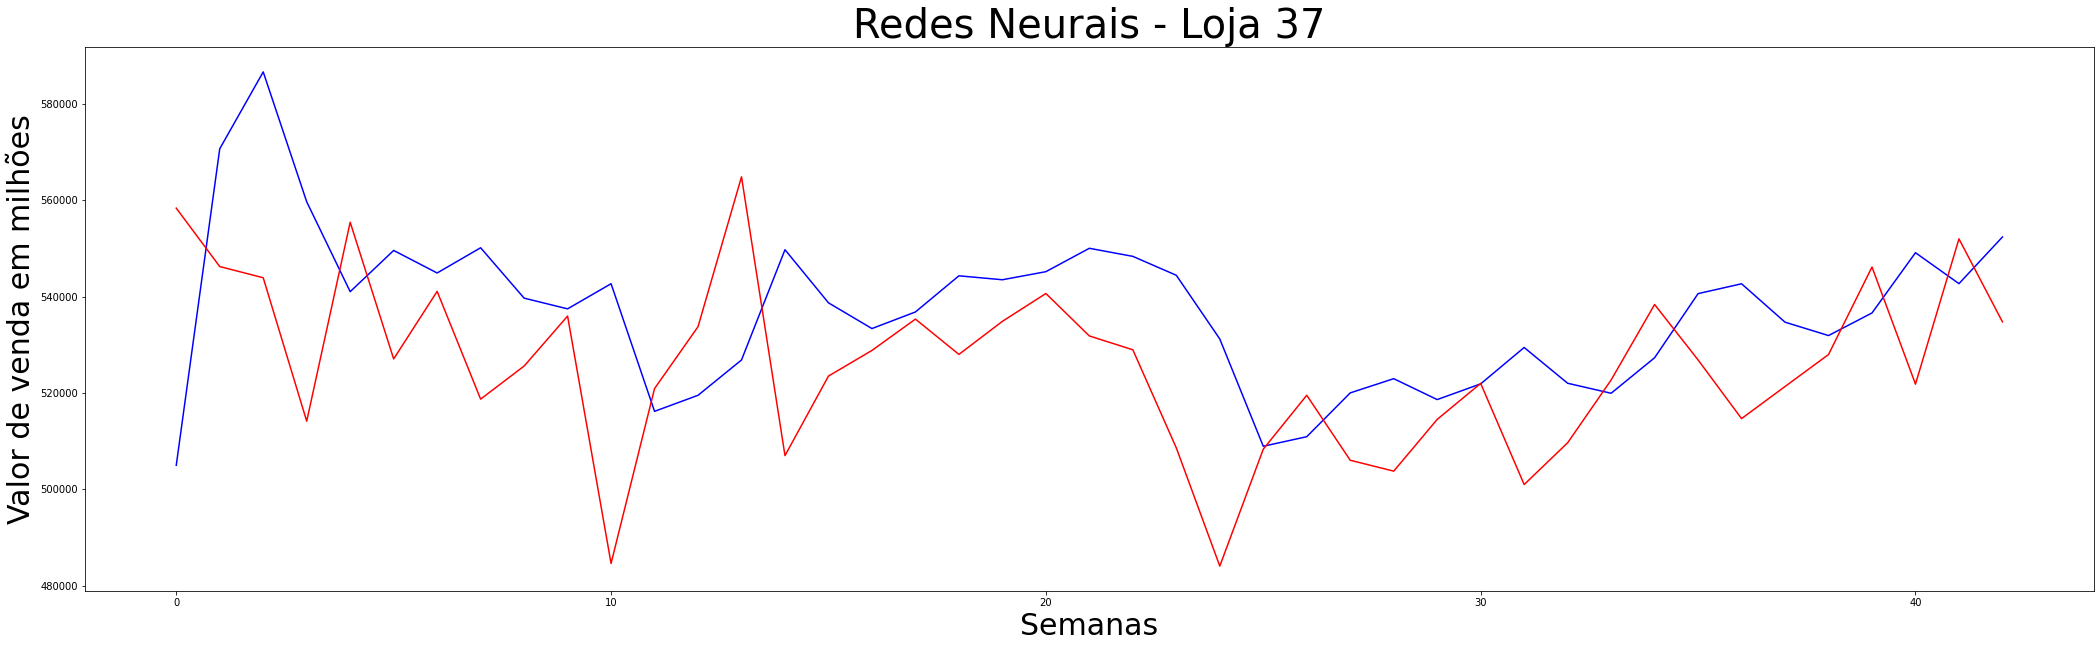

**************************************************
Resultados Loja 38:
34205.188 40295.625


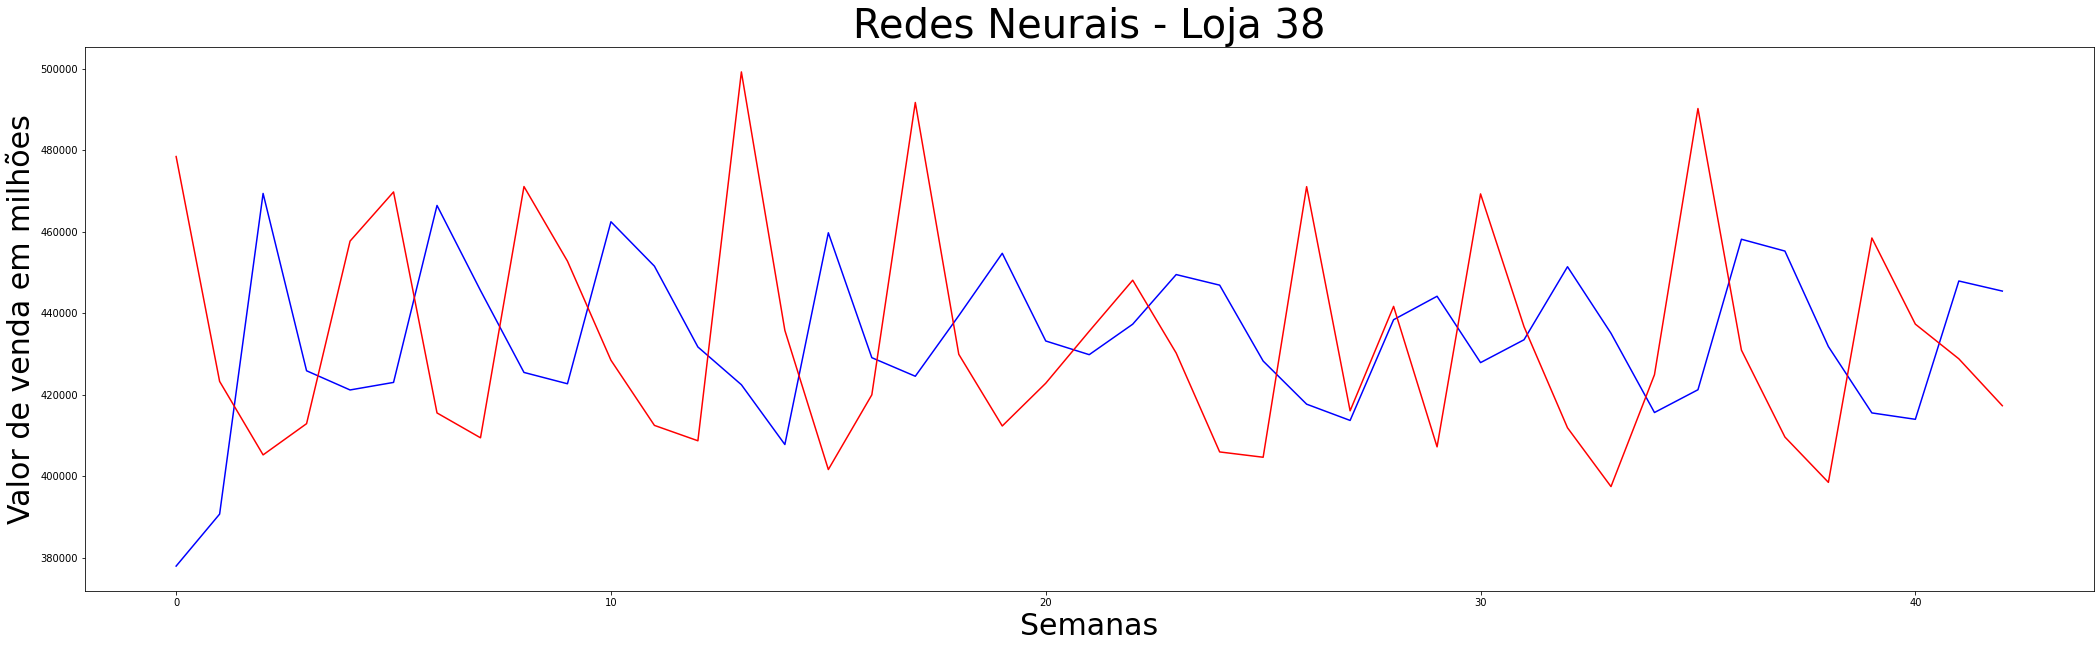

**************************************************
Resultados Loja 39:
71992.484 93025.64


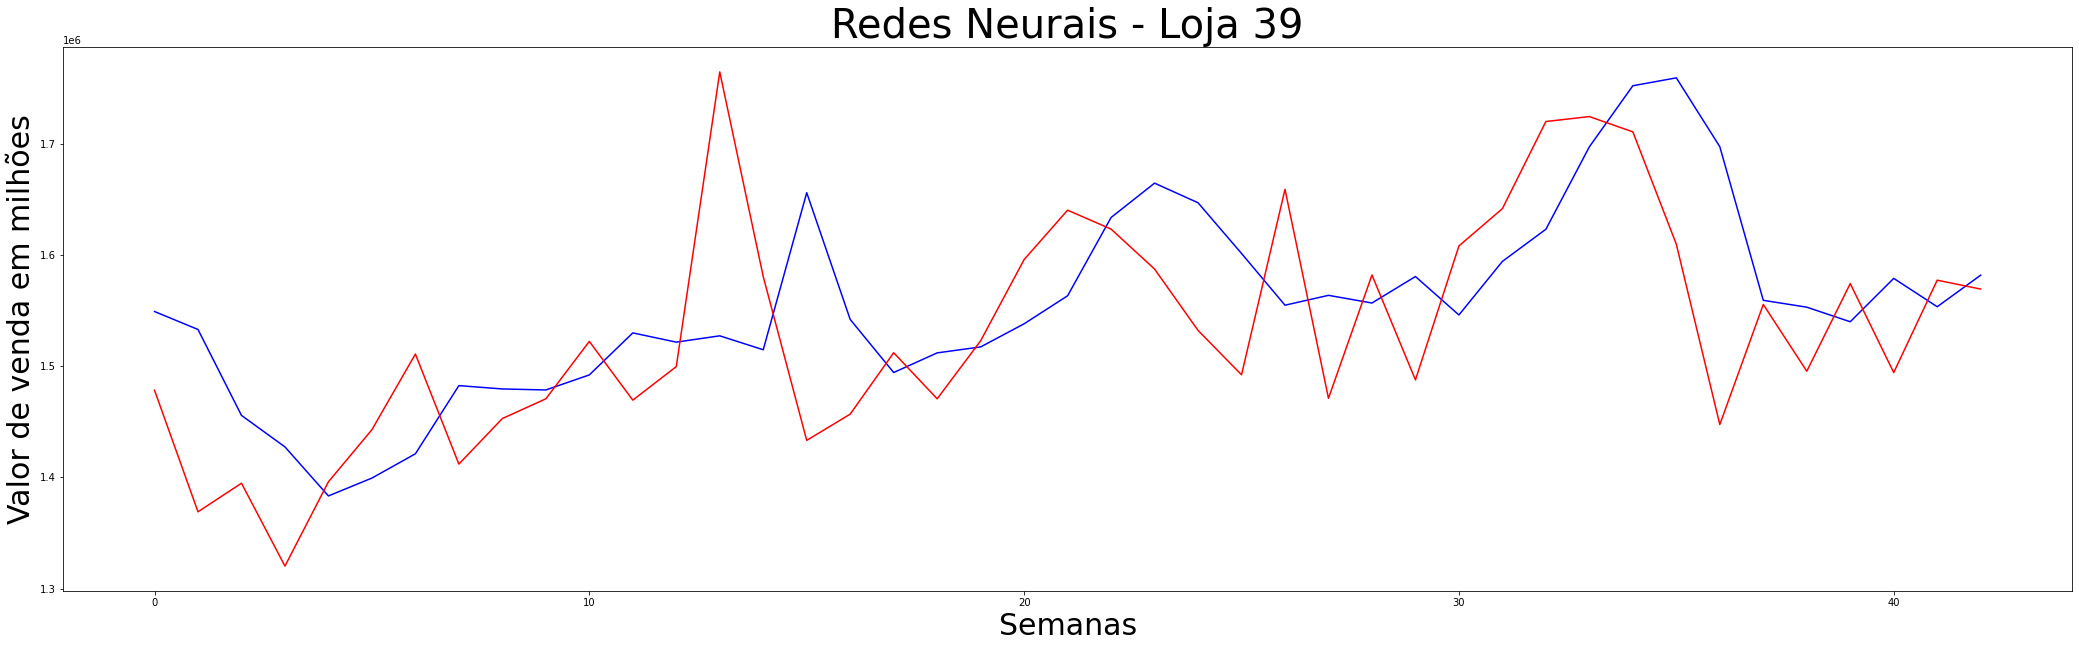

**************************************************
Resultados Loja 40:
81671.34 99100.1


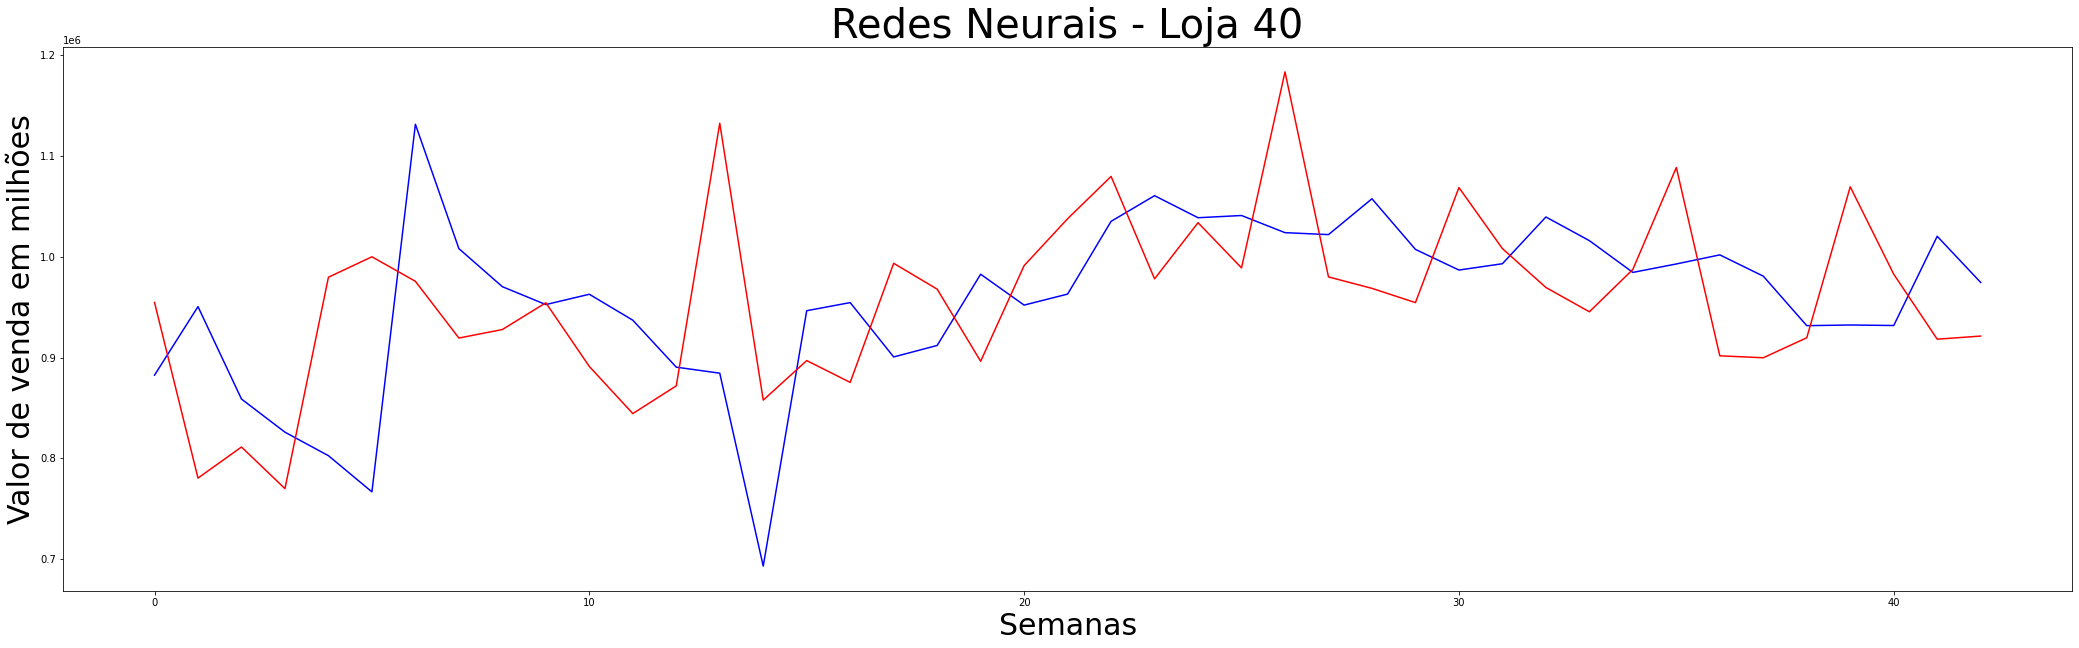

**************************************************
Resultados Loja 41:
71364.76 81694.69


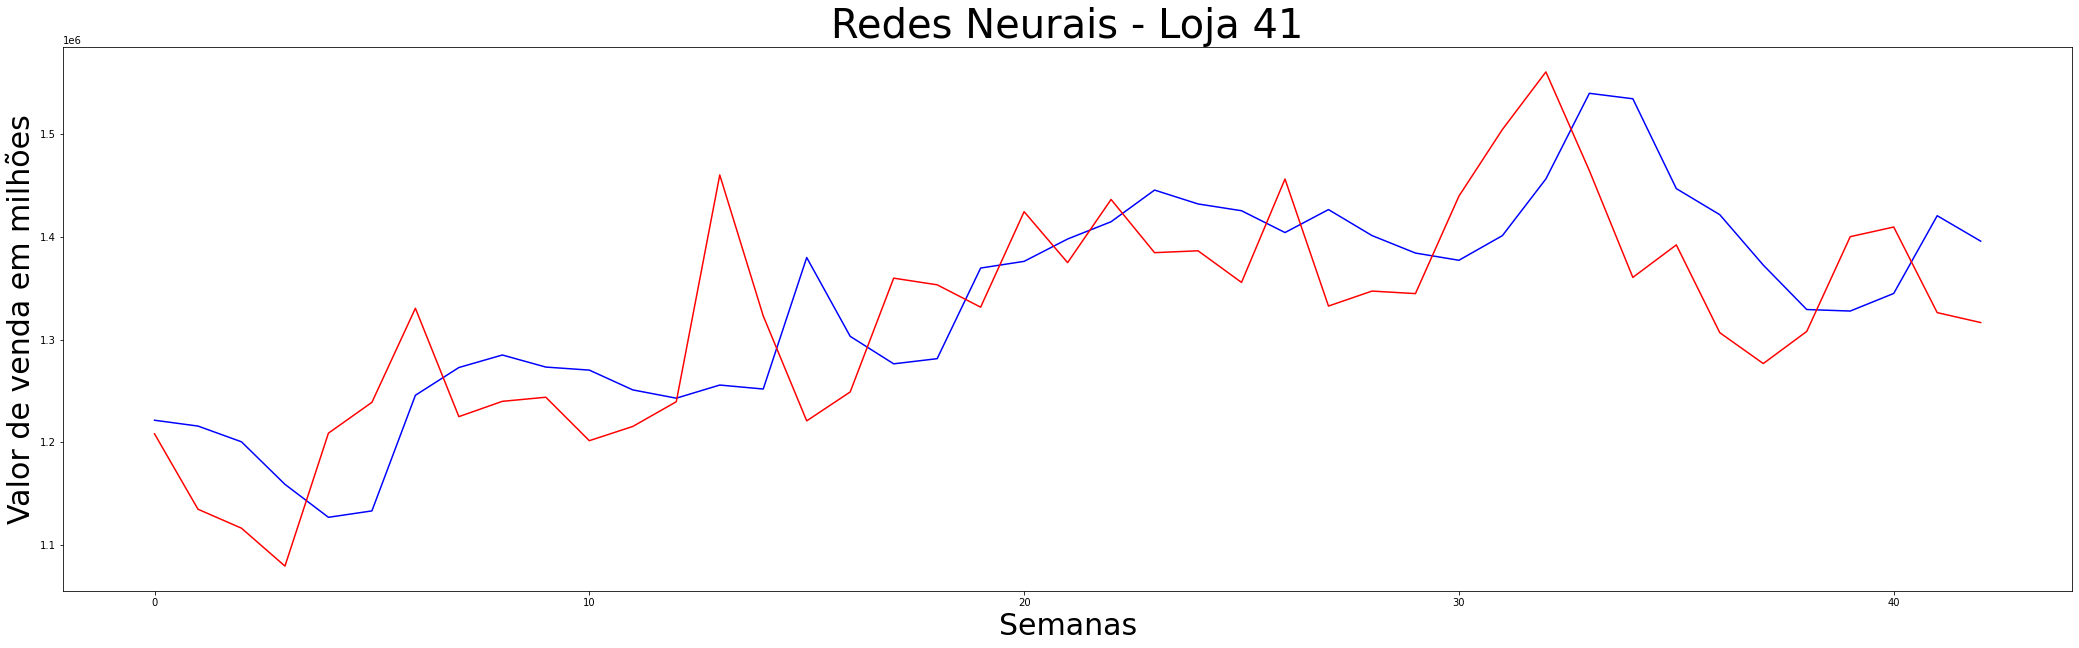

**************************************************
Resultados Loja 42:
75656.58 82448.57


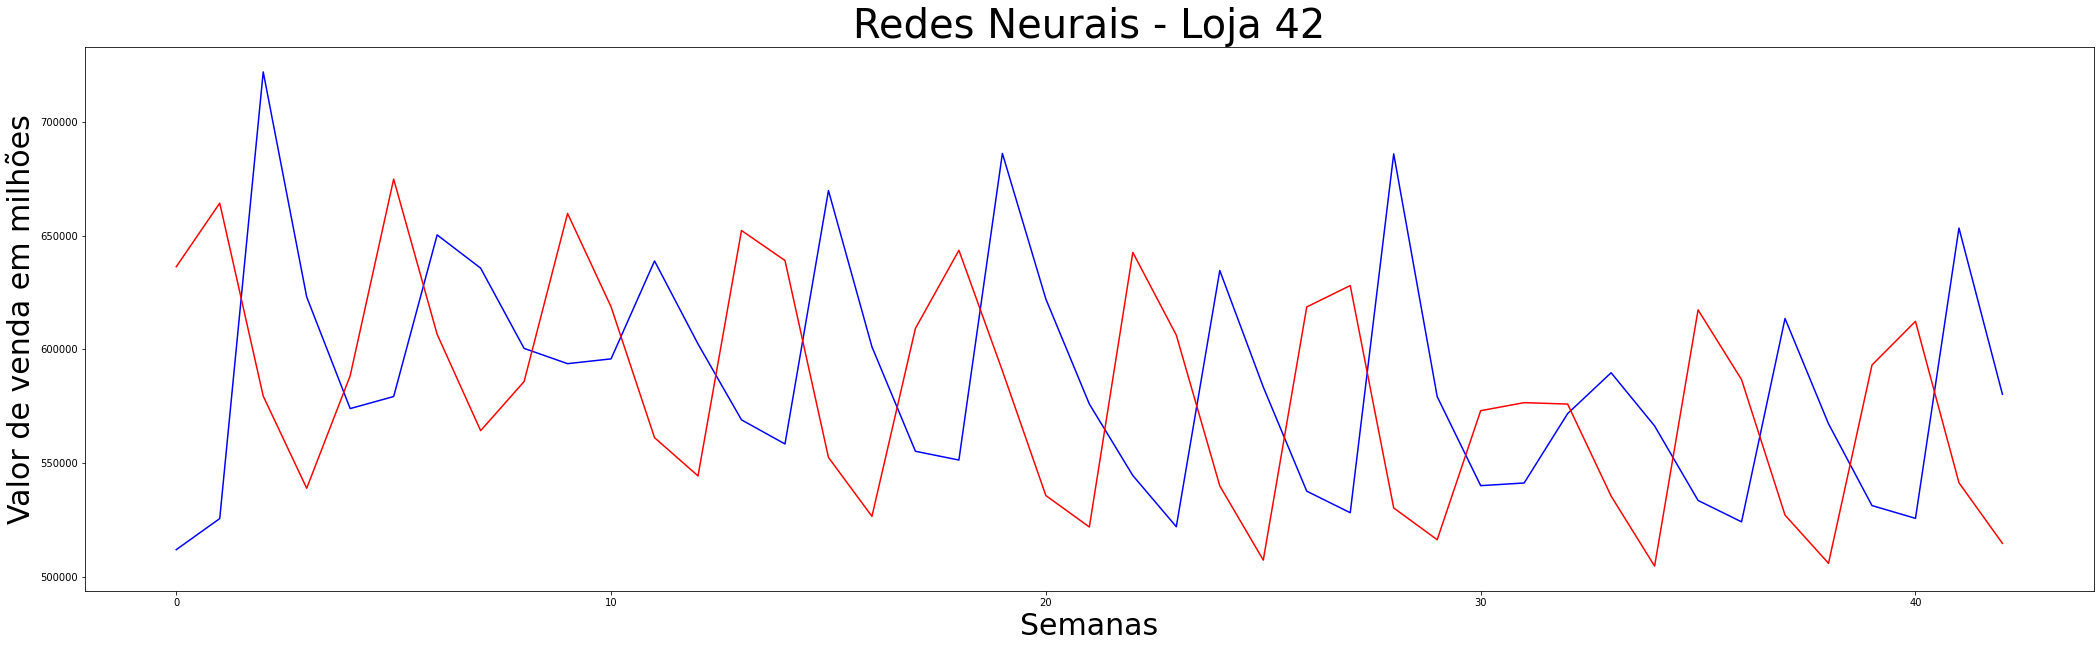

**************************************************
Resultados Loja 43:
35996.074 44963.63


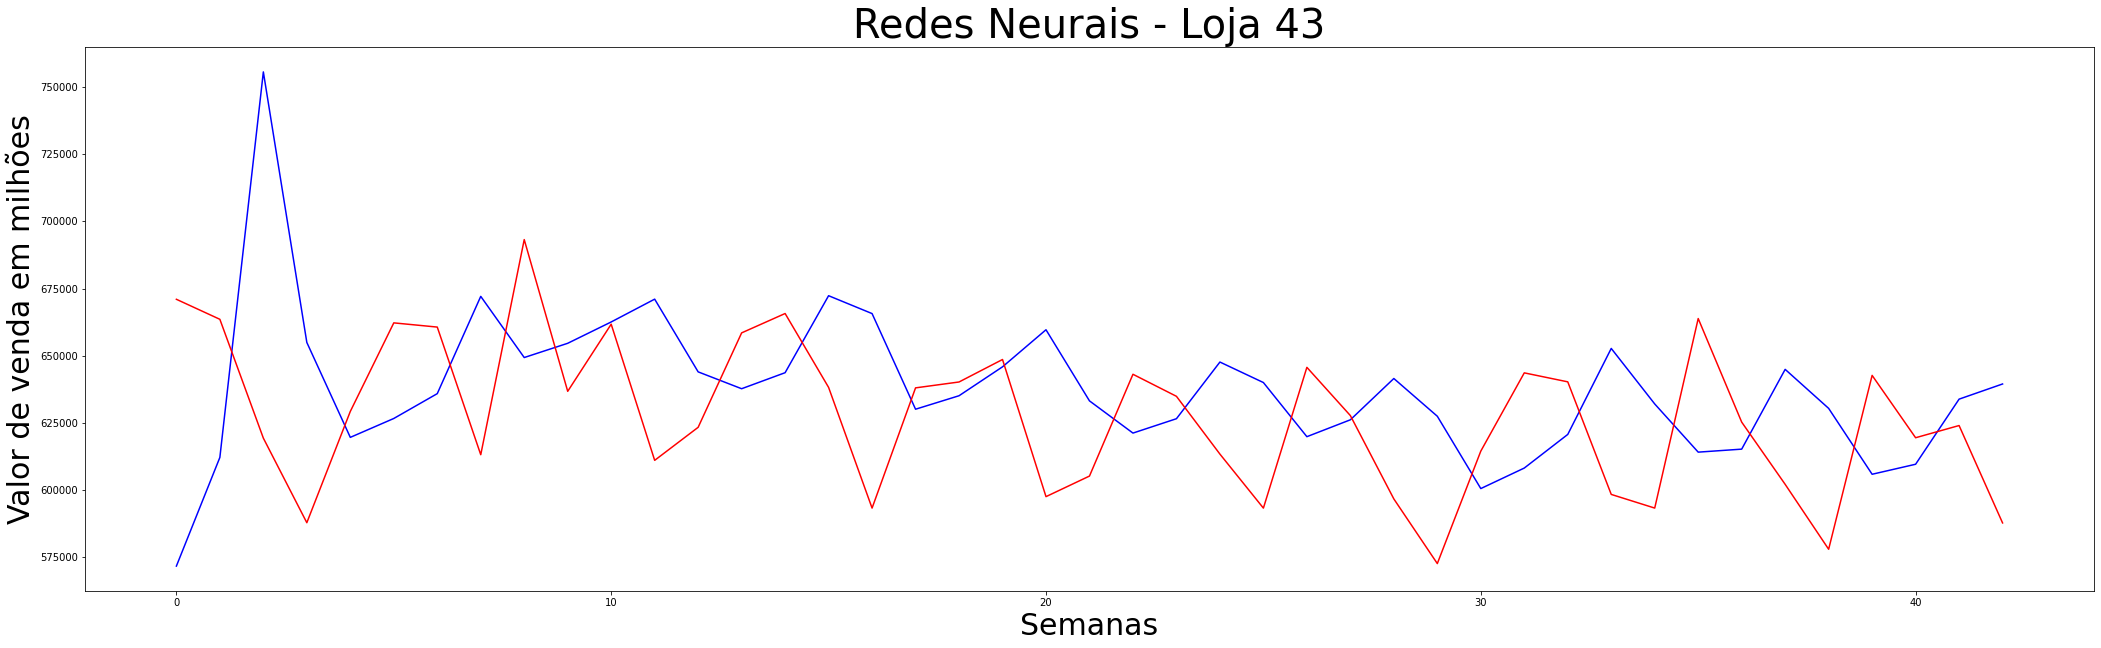

**************************************************
Resultados Loja 44:
11146.279 13736.3545


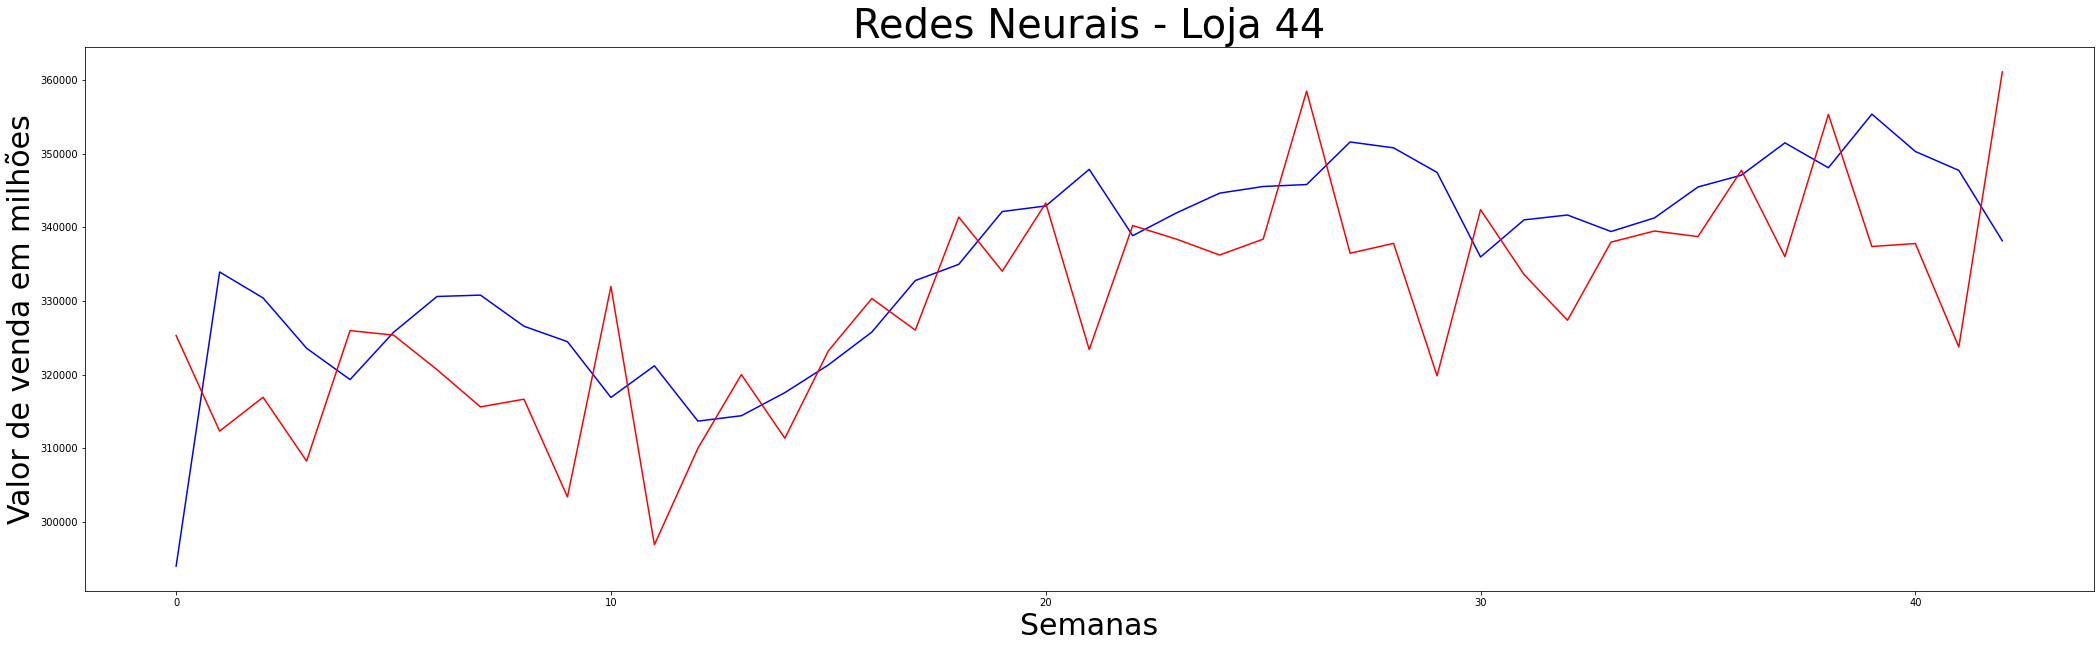

**************************************************
Resultados Loja 45:
38468.12 50931.316


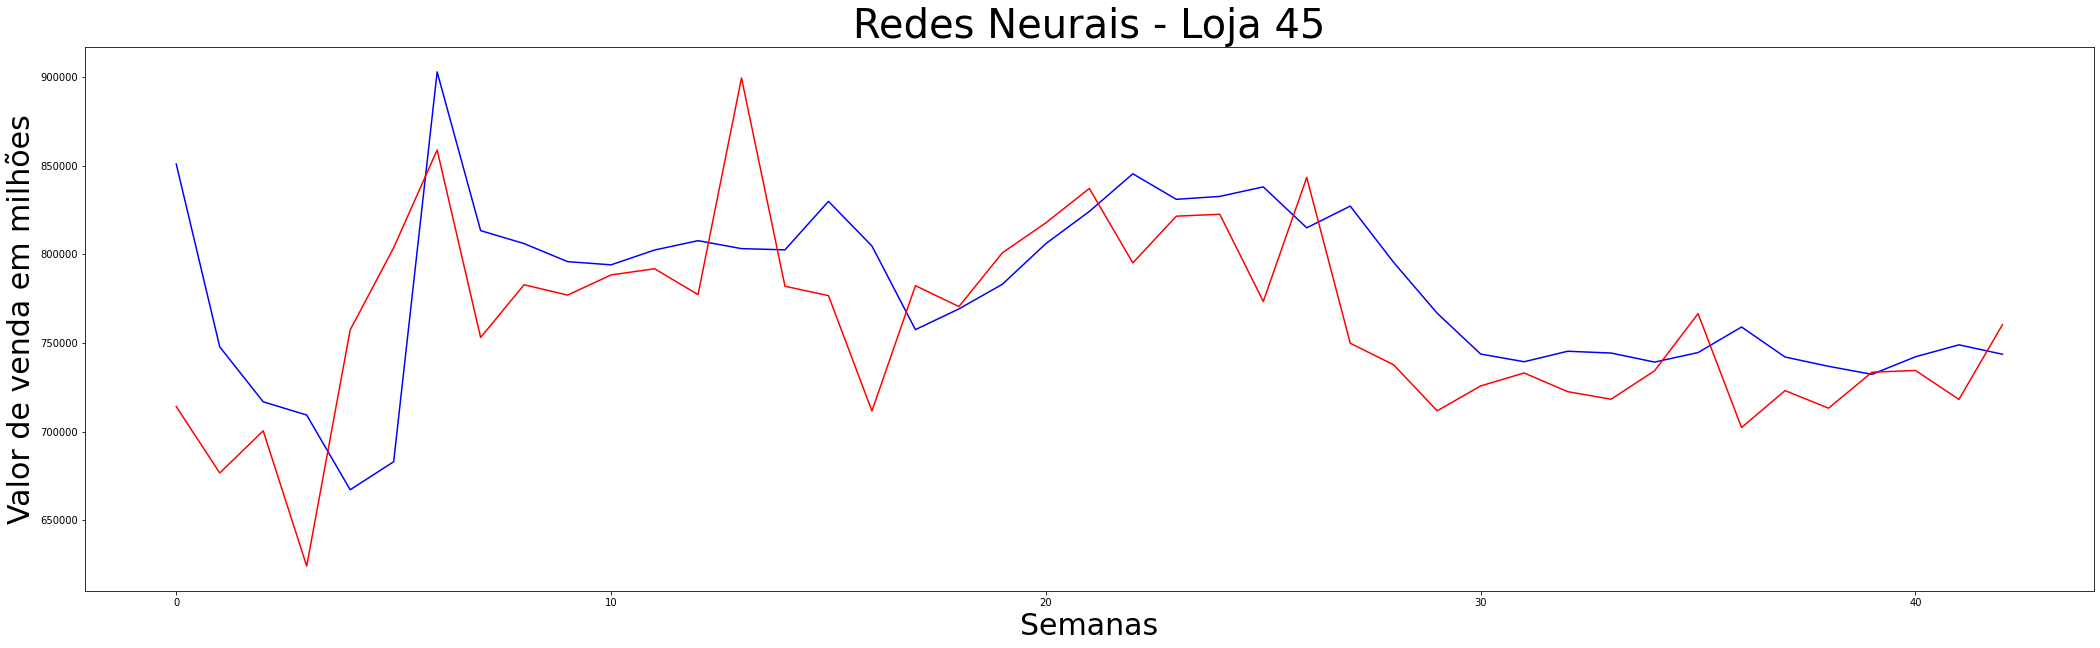

**************************************************


In [98]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = model.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Redes Neurais - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
